# Определение перспективного тарифа для телеком-компании

## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


## Описание тарифов
### Тариф «Смарт»
**Ежемесячная плата: 550 рублей**

Включено: 
- 500 минут разговора
- 50 сообщений 
- 15 Гб интернет-трафика

**Стоимость услуг сверх тарифного пакета:**
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей


### Тариф «Ультра»
**Ежемесячная плата: 1950 рублей**

Включено:
- 3000 минут разговора
- 1000 сообщений
- 30 Гб интернет-трафика

**Стоимость услуг сверх тарифного пакета:**
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

**Примечание**

*«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.*

### Описание данных
**Таблица `users` (информация о пользователях):**
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

**Таблица `calls` (информация о звонках):**
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

**Таблица `messages` (информация о сообщениях):**
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

**Таблица `internet` (информация об интернет-сессиях):**
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

**Таблица `tariffs` (информация о тарифах):**
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


### Загрузим бибилотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly
import plotly.graph_objs as go
import plotly.express as px
from datetime import datetime as dt
from scipy import stats as st

### Загрузим данные

В момент загрузки данных приведём столбцы с датами к формату `datetime`

In [2]:
# загрузим данные
# users:
try:
    users = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])
except:
    users = pd.read_csv('users.csv', parse_dates=['churn_date', 'reg_date'])
    
# calls:
try:
    calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
except:
    calls = pd.read_csv('calls.csv', parse_dates=['call_date'])
    
# messages:
try:
    messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
except:
    messages = pd.read_csv('messages.csv', parse_dates=['message_date'])
    
# internet:
try:
    internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
except:
    internet = pd.read_csv('internet.csv', parse_dates=['session_date'])

# tariffs:
try:
    tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    tariffs = pd.read_csv('tariffs.csv')

In [3]:
# Добавим функции графиков

def histplot(df, column, bins):
    fig = px.histogram(df, x=column, title=f'Histogram of {column}', nbins=bins)
    
    return fig

## Шаг 1. Обзор данных

### Users (информация о пользователях)

In [4]:
display(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Форматы данных в порядке, даты мы преобразовали в момент загрузки. В `churn_date` запонено 38 значений, остальные - NaN, то есть дата пропущена. Значит большинство тарифов за исключением 38 случаев действовало на момент выгрузки данных. В остальных столбцах пропусков нет.

### Calls (информация о звонках)

In [6]:
display(calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


В датафрейме 202607 строк. Столбцов с пропусками нет. Форматы данных в порядке.

### Messages (Информация о сообщениях)

In [8]:
display(messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


123036 строк. Пропусков нет. Форматы данных в порядке.

### Internet (информация об интернет-сессиях)

In [10]:
display(internet)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


В таблице 149396 записей об интернет-сессиях. Пропусков нет. Есть столбец `Unnamed: 0`, который дублирует порядковый номер записи. Он не несёт никакой ценной для нас информации - можно удалить этот столбец. В остальных столбцах форматы данных в порядке.

In [12]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 260.0+ bytes


В описаниях наших тарифов все значения целочисленные, кроме назваия тарифа. Типы данных в порядке. Информация соответствует, тому, что предоставил заказчик.

### Выводы из обзора данных

В данных нет пропусков. Типы данных во всех таблицах приведены к нужному формату. В таблице `internet` удалим столбец `Unnamed: 0` - он не несёт никакой полезной для нас информации.

Скорее всего данные собирались автоматически, так как нет пропусков. Поищем аномалии и дубли на этапе предобработки данных.

## Шаг 2. Предобработка данных

С типами данных у нас всё в порядке. Пропусков также нет. Поэтому сразу перейдём к поиску аномалий.

### Поиск аномалий

Таблица с информацией о тарифах имеет справочный характер, аномалий там быть не может. В таблице о соощениях, указаны только даты отправки сообщений. Эти табицы на аномалии смотреть нет смысла.

Выведем описательную статистику таблицы `users`. Числовые значения присутствуют в столбцах `age` и `user_id`.

In [14]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


Аномалий в возрасте нет. Абонентам от 18 о 75 лет.

Выведем описательную статистику таблицы `calls`

In [15]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


С длительностью звонков, судя по всему, тоже всё в порядке. Звонкии с длительностью 0 минут - это пропущенные звонки, пояснил заказчик. Максимальная длительность - 38 минут. В среднем абоненты из выборки разговаривают примерно 6,7 минут.

Выведем описательную статистику по таблице с информацией об интернет-сессиях.

In [16]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


В целом информация об истраченном трафике выглядит адекватно. Однако есть сессии со значением 0. Посмотрим сколько таких.

In [17]:
internet.query('mb_used == 0').count()

Unnamed: 0      19598
id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64

19598 раз пользователи начинали интернет сессию и завершали её не потратив ни одного мегабайта. Это 13% от всех сессий. Сложно представить, с чем может быть связано такое поведение. Если бы у нас была возможность задать вопрос заказчику, мы бы это сделали.

Однако так как такой возможности у нас нет, оставим в датафрейме только те строки, где был израсходован трафик.

Удалим стобец `Unnamed: 0`

In [18]:
internet = internet.loc[internet['mb_used'] > 0]

In [19]:
internet = internet.drop(['Unnamed: 0'], axis = 1)

### Поиск и удаление дубликатов

Поищем дубликаты в списках абонентов, информации о звоках и интернет-сессиях

In [20]:
users.duplicated().sum()

0

In [21]:
calls.duplicated().sum()

0

In [22]:
internet.duplicated().sum()

0

Дубликатов в наших датасетах нет.

**Выводы.** Аномалий и дубликатов в наших данных нет. Единственной, что мы сделали - удалили строки, где за интернет-сессию совсем не было израсходовано трафика. Заказчик предоставил достаточно чистые данные. Можем переходить к дополнительным расчётам.

 ### Расчёты дополнительных параметров

Посчитаем для каждого пользователя:


- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Пропишем функцию, котрая будет извлекать месяц из даты и добавлять его в отдельный столбец, указанного датафрейма.

In [23]:
def get_month(df, column):
    df['month'] = df[column].dt.month

Применим нашу функцию для датафреймов `calls`, `messages`, `internet`.

In [24]:
get_month(calls,'call_date')
get_month(messages,'message_date')
get_month(internet,'session_date')

In [25]:
display(calls)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


Округлим длительность каждого звонка в таблице со звонками согласно политике учёта оператора.

In [26]:
calls['duration_rounded'] = np.ceil(calls['duration']).astype(int)

Посчитаем длительность и количество звонков для каждого пользователя по месяцам

In [27]:
users_calls_by_month = calls.groupby(['user_id', 'month'])\
                       .agg({'duration_rounded': 'sum',
                           'id': 'count'}) \
                       .reset_index() \
                       .rename(columns = {'duration_rounded':'calls_duration_by_month',
                                         'id':'calls_by_month'})

In [28]:
users_calls_by_month

,user_id,month,calls_duration_by_month,calls_by_month
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
...,...,...,...,...
3169,1498,10,247,41
3170,1499,9,70,9
3171,1499,10,449,68
3172,1499,11,612,74


Посчитаем количество сообщений для каждого абонента по месяцам.

In [29]:
users_messages_by_months = messages.groupby(['user_id', 'month'])\
                .agg({'id': 'count'})\
                .reset_index()\
                .rename(columns = {'id':'messages_by_month'})

In [30]:
users_messages_by_months # выведем количество сообщений по каждому абоненту по месяцам

,user_id,month,messages_by_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [31]:
internet

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149390,1499_151,752.72,2018-10-11,1499,10
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149394,1499_155,1246.32,2018-11-26,1499,11


Посчитаем объём израсходованного трафика по месяцам для каждого абонента согласно учётной политике оператора, переведём мегабайты в гигабайты.

In [32]:
users_traffic_by_month = internet.groupby(['user_id','month'])\
                .agg({'mb_used':'sum'})\
                .reset_index()\
                .rename(columns = {'mb_used':'traffic_by_month'}) # посчитаем количество мегабайт в месяц для каждого абонента

# переведём мегабайты в гигабайты
users_traffic_by_month['traffic_by_month'] = users_traffic_by_month['traffic_by_month'] / 1024
# округлим количество гигагабайт в большую сторону
users_traffic_by_month['traffic_by_month'] = users_traffic_by_month['traffic_by_month'].apply(np.ceil).astype(int)

In [33]:
users_traffic_by_month # посмотрим, что получилось

,user_id,month,traffic_by_month
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15
...,...,...,...
3196,1498,10,21
3197,1499,9,2
3198,1499,10,18
3199,1499,11,18


Объединим три таблицы с использованными минутами, сообщениями и трафиком по месяцам способом `outer`

In [34]:
# объединим звонки и сообщения
users_used_up = users_calls_by_month.merge(users_messages_by_months, on = ['user_id', 'month'], how = 'outer')

In [35]:
# объединим таблицу со звонками и сообщениями с таблицей с интернет-трафиком
users_used_up =  users_used_up.merge(users_traffic_by_month, on = ['user_id', 'month'], how = 'outer')

In [36]:
users_used_up

,user_id,month,calls_duration_by_month,calls_by_month,messages_by_month,traffic_by_month
0,1000,5,159.0,22.0,22.0,3.0
1,1000,6,172.0,43.0,60.0,23.0
2,1000,7,340.0,47.0,75.0,14.0
3,1000,8,408.0,52.0,81.0,14.0
4,1000,9,466.0,58.0,57.0,15.0
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17.0
3210,1489,10,NaN,NaN,21.0,20.0
3211,1489,11,NaN,NaN,20.0,18.0
3212,1489,12,NaN,NaN,35.0,17.0


Добавим в `users_used_up` информацию о каждом абоненте и информацию о тарифах для каждого абонента

In [37]:
users_used_up = users_used_up.merge(users, how = 'outer', left_on = 'user_id', right_on = 'user_id')

In [38]:
users_used_up = users_used_up.merge(tariffs, how = 'left', left_on = 'tariff', right_on = 'tariff_name')

In [39]:
pd.set_option('display.max_columns', 50) # увеличим количество выводимых столбцов в DF, чтобы увидеть все столбцы в датасете

In [40]:
users_used_up

,user_id,month,calls_duration_by_month,calls_by_month,messages_by_month,traffic_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3212,1489,11.0,NaN,NaN,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3213,1489,12.0,NaN,NaN,35.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,ultra


Мы видим пропуски в количестве и длительности звонков, количестве сообщений и объёмах использованного интернет-трафика. Заменим NaN на нули.

In [41]:
users_used_up[['calls_duration_by_month', 'calls_by_month', 'messages_by_month', 'traffic_by_month']] = users_used_up[['calls_duration_by_month', 'calls_by_month', 'messages_by_month', 'traffic_by_month']].fillna(0)

In [42]:
users_used_up

,user_id,month,calls_duration_by_month,calls_by_month,messages_by_month,traffic_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3212,1489,11.0,0.0,0.0,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3213,1489,12.0,0.0,0.0,35.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3214,1128,NaN,0.0,0.0,0.0,0.0,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,ultra


Теперь мы можем посчитать помесячную выручку `revenue` с каждого пользователя (вычтем бесплатный лимит (`minutes_included`, `messages_included`, `mb_per_month_included`), из суммарного количества звонков `calls_duration_by_month`, сообщений `messages_by_month` и интернет-трафика`traffic_by_month`; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [43]:
# создадим функцию, которая возвращает сумму денег за использованные сверх тарифа минуты, сообщения и трафик
def tariff_excess(df):
    calls = (df['calls_duration_by_month'] - df['minutes_included']) * df['rub_per_minute']
    messages = (df['messages_by_month'] - df['messages_included']) * df['rub_per_message']
    internet = ((df['traffic_by_month'] - df['mb_per_month_included'] / 1024)) * df['rub_per_gb']
    
    excess = 0
    for value in [calls, messages, internet]:
        if value > 0:
            excess += value
    
    return excess

Применим функцию `tariff_excess` к нашему датасету, чтобы получить доход с каждого пользователя за месяц.

In [44]:
users_used_up['revenue'] = users_used_up.apply(tariff_excess, axis = 1) + users_used_up['rub_monthly_fee']

In [45]:
users_used_up

,user_id,month,calls_duration_by_month,calls_by_month,messages_by_month,traffic_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,1150.0
3213,1489,12.0,0.0,0.0,35.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,950.0
3214,1128,NaN,0.0,0.0,0.0,0.0,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0


In [46]:
users_used_up['month'].isna().sum()

2

Мы видим двух пользователей, которые не пользовались нашими услугами. Удалим их из датасета.

In [47]:
users_used_up[users_used_up['month'].isna()]

,user_id,month,calls_duration_by_month,calls_by_month,messages_by_month,traffic_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
3214,1128,NaN,0.0,0.0,0.0,0.0,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3215,1371,NaN,0.0,0.0,0.0,0.0,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3,smart,550.0


In [48]:
users_used_up = users_used_up.drop(index=[3214, 3215])

Мы провели все дополнительные вычисления. Теперь Можем перейти к анализу.

## Шаг 3. Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишием распределения.

Разделим пользователей на отдельные датафреймы по типу тарифа.

In [49]:
smart = users_used_up[users_used_up['tariff'] == 'smart']
ultra = users_used_up[users_used_up['tariff'] == 'ultra']

`calls_duration_by_month` - длительность разговоров
`messages_by_month` - сообщения за месяц
`traffic_by_month` - использованный трафик за месяц

### Минуты разговора: среднее, медиана, дисперсия, стандартное отклонение

Посмотрим как распределено количество звонков с разной длительностью в целом по году в тарифах `smart` и `ultra`. Посторим гистограммы.

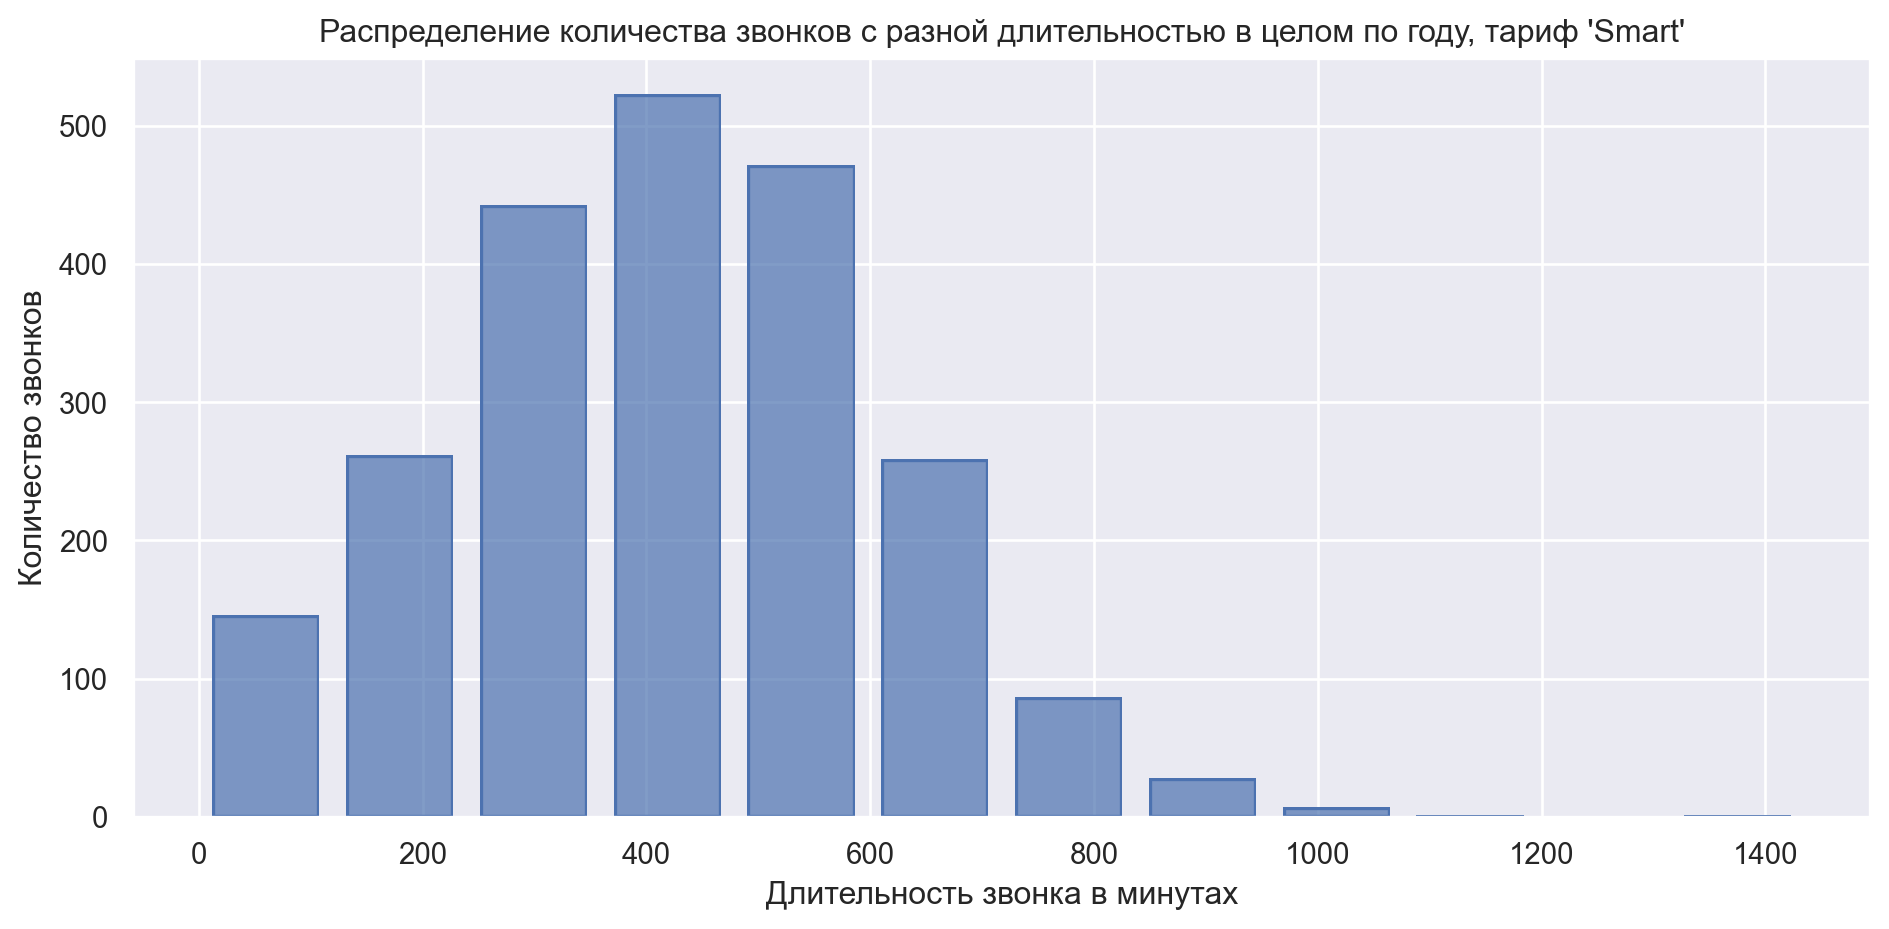

In [50]:
# Построим гистограмму для распределения длительности звонков по году в тарифе Smart
so.Plot(smart, "calls_duration_by_month").add(so.Bar(), so.Hist(bins=12))\
.label(title="Распределение количества звонков с разной длительностью в целом по году, тариф 'Smart'", 
       x="Длительность звонка в минутах", y="Количество звонков").layout(size=(10, 5))

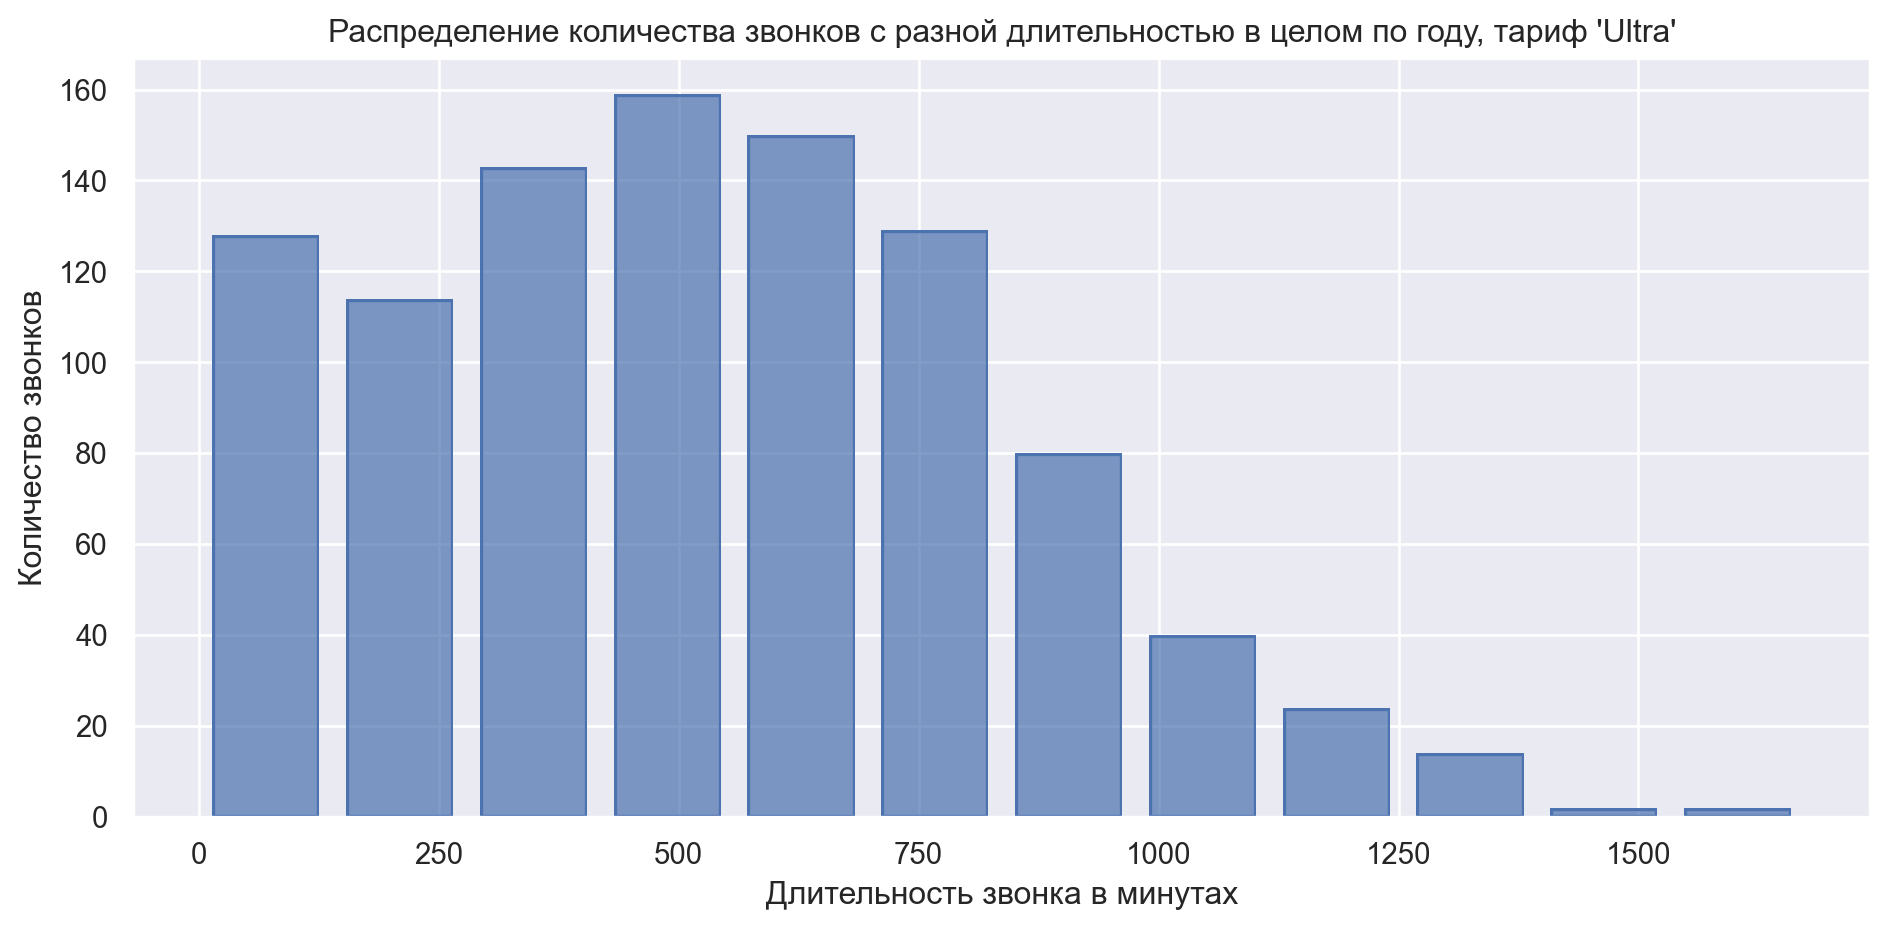

In [51]:
# Построим гистограмму для распределения длительности звонков по году в тарифе Ultra
so.Plot(ultra, "calls_duration_by_month").add(so.Bar(), so.Hist(bins=12))\
.label(title="Распределение количества звонков с разной длительностью в целом по году, тариф 'Ultra'", 
       x="Длительность звонка в минутах", y="Количество звонков").layout(size=(10, 5))

Представим оба распредения на одном графике для наглядности.

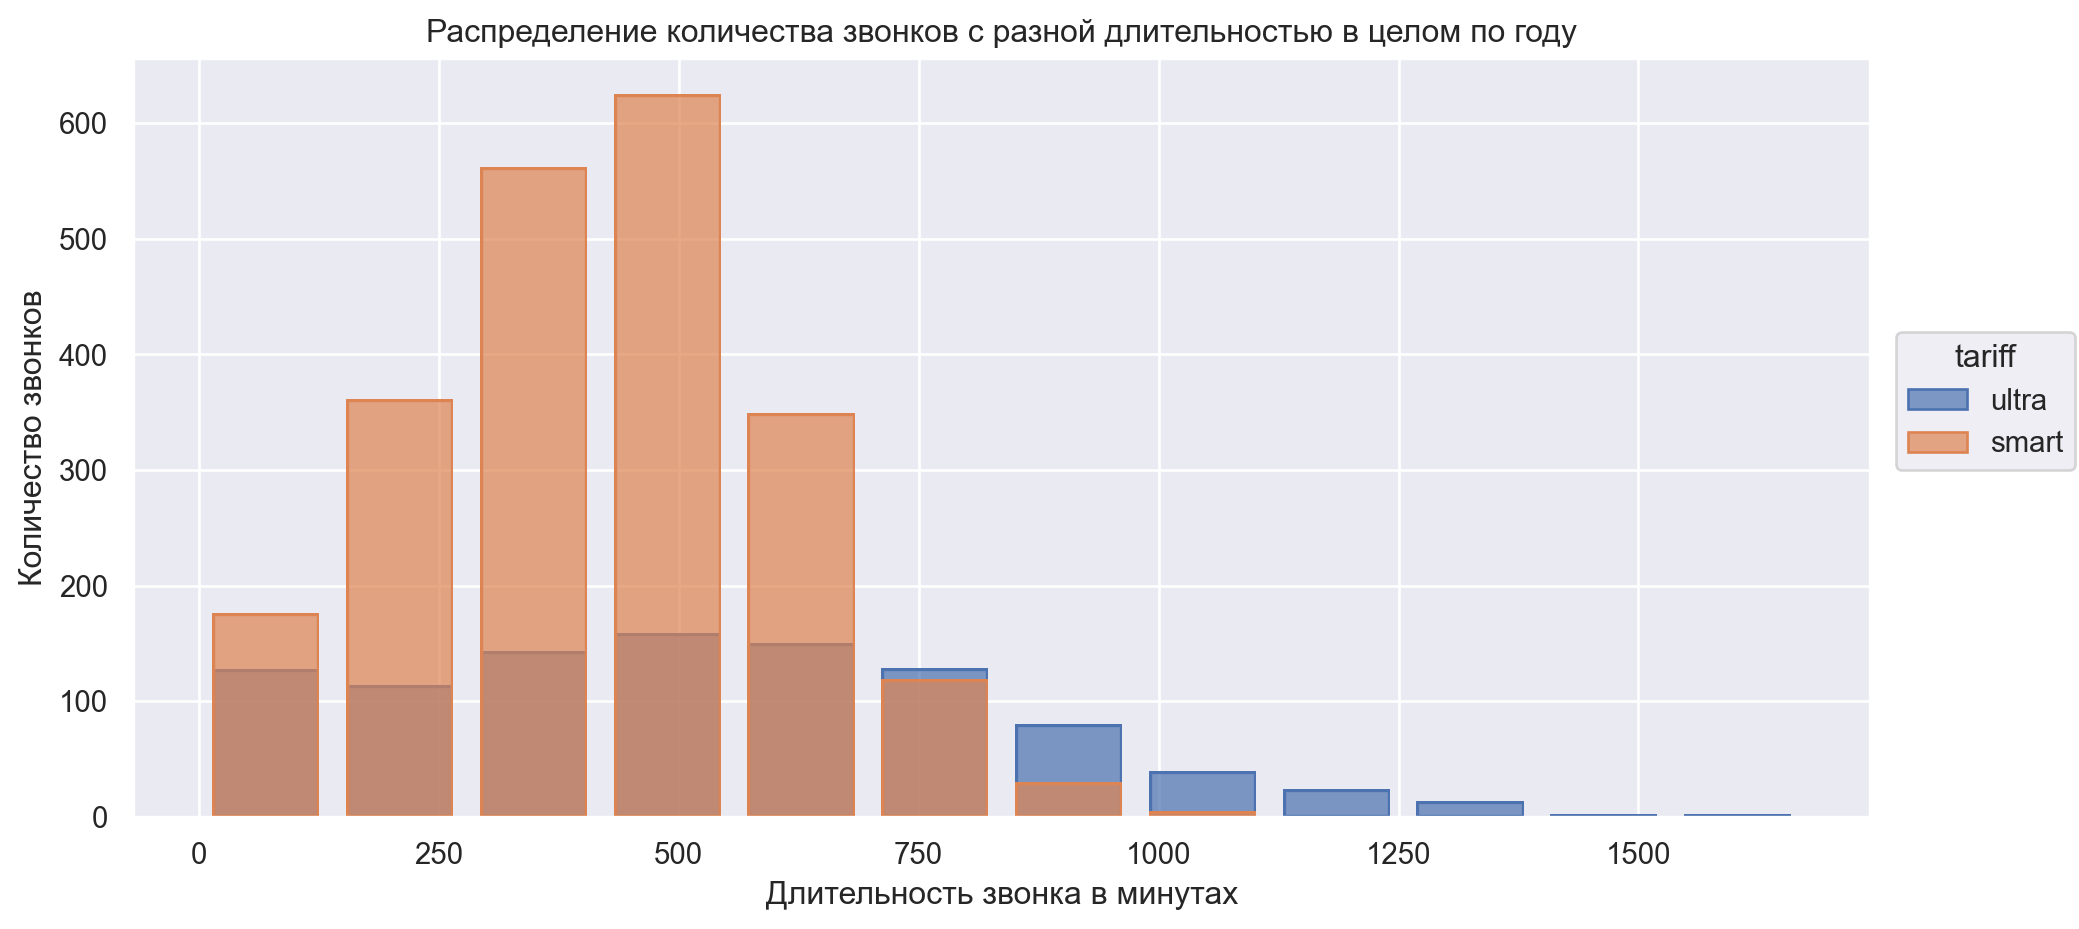

In [52]:
so.Plot(users_used_up, "calls_duration_by_month").add(so.Bar(), so.Hist(bins=12), color = 'tariff')\
.label(title="Распределение количества звонков с разной длительностью в целом по году", 
       x="Длительность звонка в минутах", y="Количество звонков").layout(size=(10, 5))

В обоих тарифах пик достигается в промежутке 300-500 минут в месяц. Однако в тарифе `ultra` в целом значения сдвинуты вправо, и пиковые значения не так ярко выражены, как в `smart`. В `ultra` достаточно большая часть пользователей наговаривает от 800 до 1400 минут в месяц, чего не скажешь о пользователях тарифа `smart`.  Значит длительность звонков в этом тарифе больше. Также в тарифе `ultra` есть значительное количество абонентов, которые разговаривали менеее 200 минут в месяц, в тарифе `smart` доля таких пользователей меньше.

Посчитаем среднее количество, дисперсию и стандартное отклонение продолжительности звонков в обоих тарифах по месяцам.

In [53]:
smart_calls_mean_duration = smart.groupby('month').agg({'calls_duration_by_month':['mean','median','var','std']}).round(2)
smart_calls_mean_duration

calls_duration_by_month                         
                         mean median       var     std
month                                                 
1.0                    203.85  162.5  23787.34  154.23
2.0                    298.69  258.0  36412.29  190.82
3.0                    390.05  409.0  36823.16  191.89
4.0                    367.13  368.5  34778.21  186.49
5.0                    387.36  433.0  34820.06  186.60
6.0                    395.64  400.0  30742.92  175.34
7.0                    408.35  414.0  32250.27  179.58
8.0                    421.47  432.0  34793.58  186.53
9.0                    428.61  435.0  33535.34  183.13
10.0                   426.14  427.5  35392.34  188.13
11.0                   435.27  428.5  31605.24  177.78
12.0                   478.56  471.0  39698.62  199.25

In [54]:
smart_calls_mean_duration['calls_duration_by_month']['mean']

month
1.0     203.85
2.0     298.69
3.0     390.05
4.0     367.13
5.0     387.36
6.0     395.64
7.0     408.35
8.0     421.47
9.0     428.61
10.0    426.14
11.0    435.27
12.0    478.56
Name: mean, dtype: float64

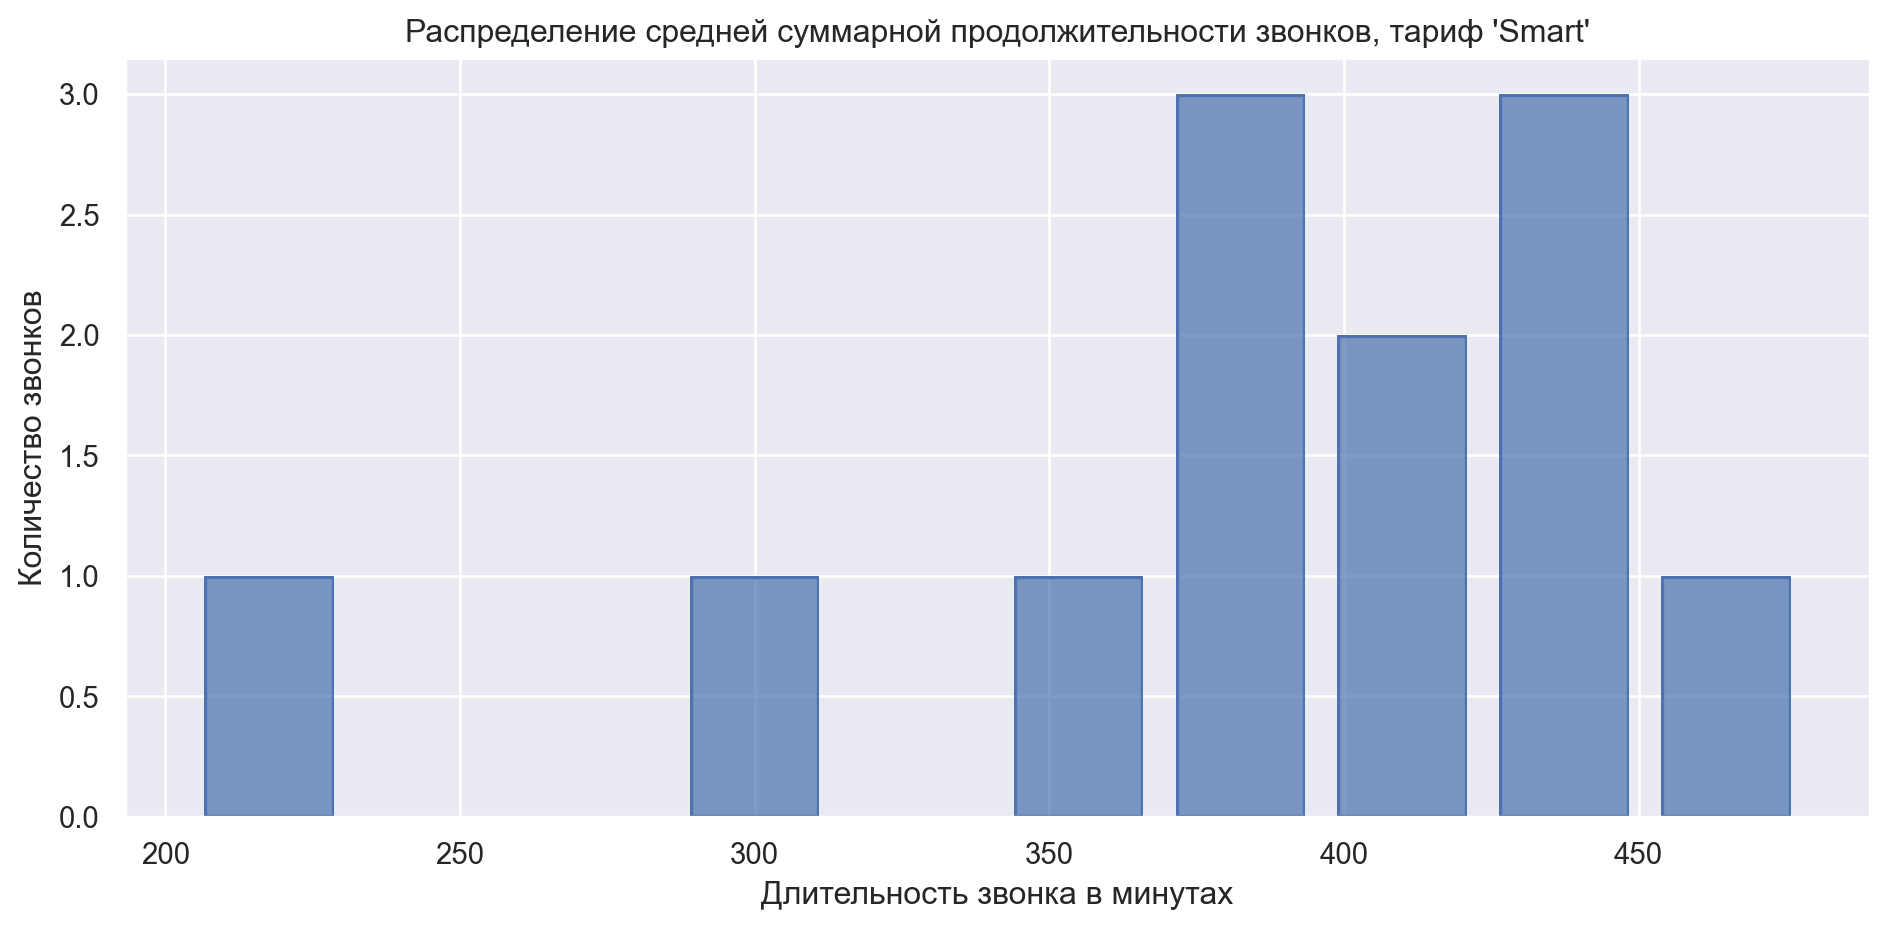

In [55]:
so.Plot(smart_calls_mean_duration['calls_duration_by_month']['mean']).add(so.Bar(), so.Hist(bins=10))\
.label(title="Распределение средней суммарной продолжительности звонков, тариф 'Smart'", 
       x="Длительность звонка в минутах", y="Количество звонков").layout(size=(10, 5))

In [56]:
ultra_calls_mean_duration = ultra.groupby('month').agg({'calls_duration_by_month':['mean','median','var','std']}).round(2)
ultra_calls_mean_duration

calls_duration_by_month                          
                         mean median        var     std
month                                                  
1.0                    428.11  382.0   72769.36  269.76
2.0                    297.12  168.0   87919.68  296.51
3.0                    489.65  403.0  111384.90  333.74
4.0                    458.02  453.0   71653.87  267.68
5.0                    510.33  519.0   83870.19  289.60
6.0                    479.70  479.0   91535.95  302.55
7.0                    545.79  542.0   94322.28  307.12
8.0                    510.78  500.0   97956.50  312.98
9.0                    539.44  520.0  105716.78  325.14
10.0                   558.08  533.0  106464.58  326.29
11.0                   541.38  546.0   96570.06  310.76
12.0                   592.81  584.0  117276.33  342.46

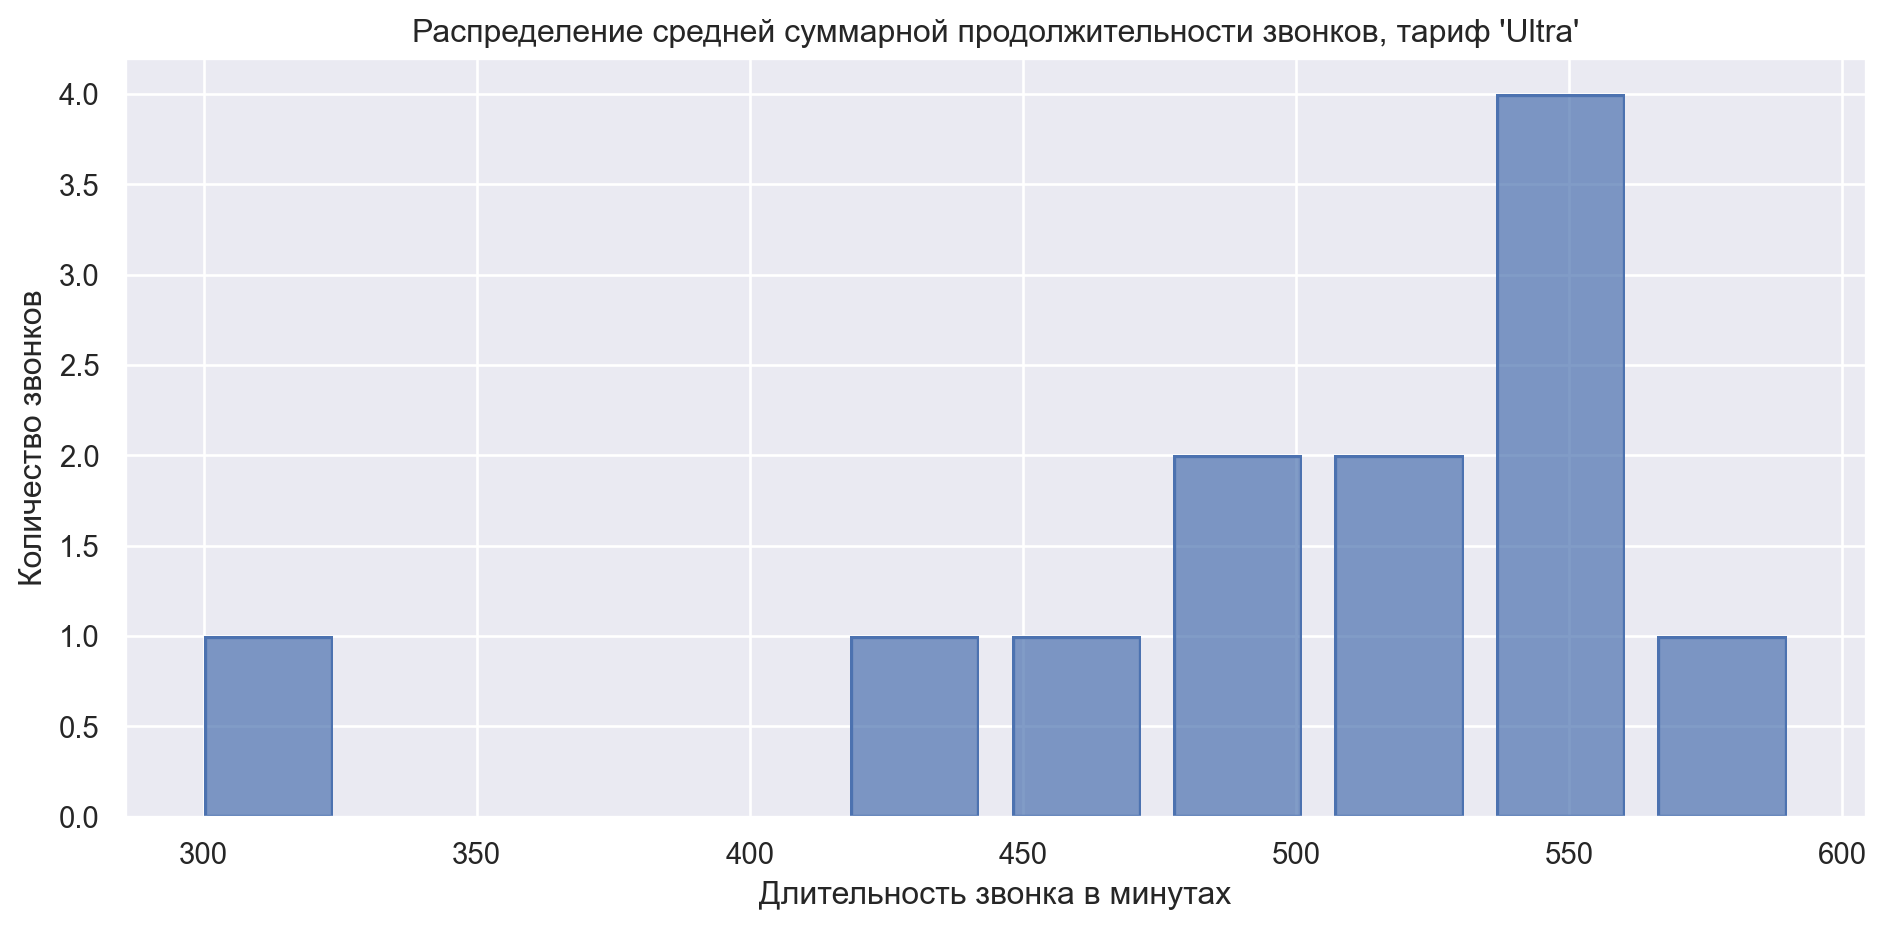

In [57]:
so.Plot(ultra_calls_mean_duration['calls_duration_by_month']['mean']).add(so.Bar(), so.Hist(bins=10))\
.label(title="Распределение средней суммарной продолжительности звонков, тариф 'Ultra'", 
       x="Длительность звонка в минутах", y="Количество звонков").layout(size=(10, 5))

В тарифе ultra средняя суммарная продолжительность звонков больше. Только в одном месяце этот показатель находится в диапазоне от 200 до 300 минут. 4 месяца в диапазоне от 400 до 500 минут, и 7 месяцев в диапазоне от 500 до 600 минут.

Построим график со средними значениями продолжительности разговоров по месяцам для каждого тарифа и сравним их на графике

In [58]:
month_calls_duration = users_used_up.pivot_table(
    index=['month', 'tariff'],
    values='calls_duration_by_month',
    aggfunc='mean'
).reset_index()


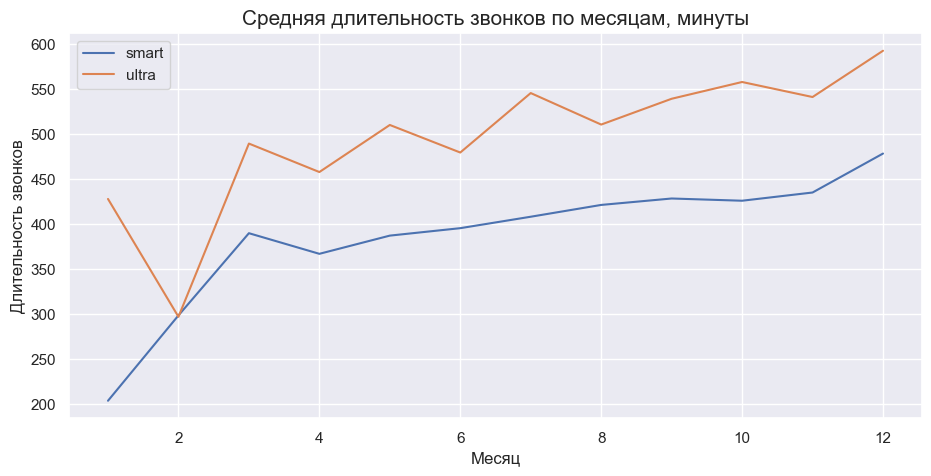

In [59]:
sns.set(rc={'figure.figsize':(11, 5)})
ax = sns.lineplot(data=month_calls_duration, x="month", y="calls_duration_by_month", hue="tariff")
ax.set_title('Средняя длительность звонков по месяцам, минуты', fontsize = 15)
ax.set_xlabel("Месяц")
ax.set_ylabel("Длительность звонков")
ax.legend(loc="upper left");

Построим график со средним количеством звонков по месяцам для каждого тарифа.

In [60]:
month_count_calls = users_used_up.pivot_table(
    index=['month', 'tariff'],
    values='calls_by_month',
    aggfunc='mean'
).reset_index()

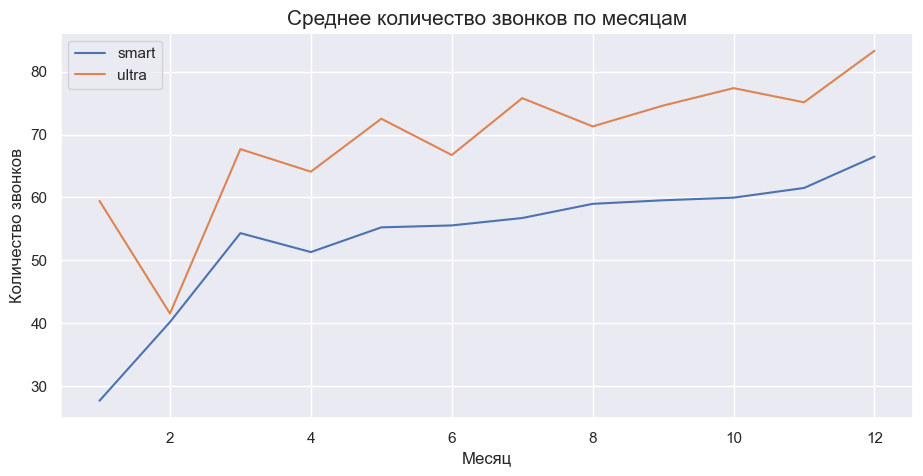

In [61]:
sns.set(rc={'figure.figsize':(11, 5)})
ax = sns.lineplot(data=month_count_calls, x="month", y="calls_by_month", hue="tariff")
ax.set_title('Среднее количество звонков по месяцам', fontsize = 15)
ax.set_xlabel("Месяц")
ax.set_ylabel("Количество звонков")
ax.legend(loc="upper left");

По графикам также видно, что и средняя продолжительность по месяцам и среднее количество звонков в тарифе `ultra` выше, чем в тарифе `smart`.

### Сообщения: среднее, медиана, дисперсия, стандартное отклонение

Посмотрим как распределено среднее количество отправленных сообщений в месяцам в тарифах `smart` и `ultra` в целом по году.

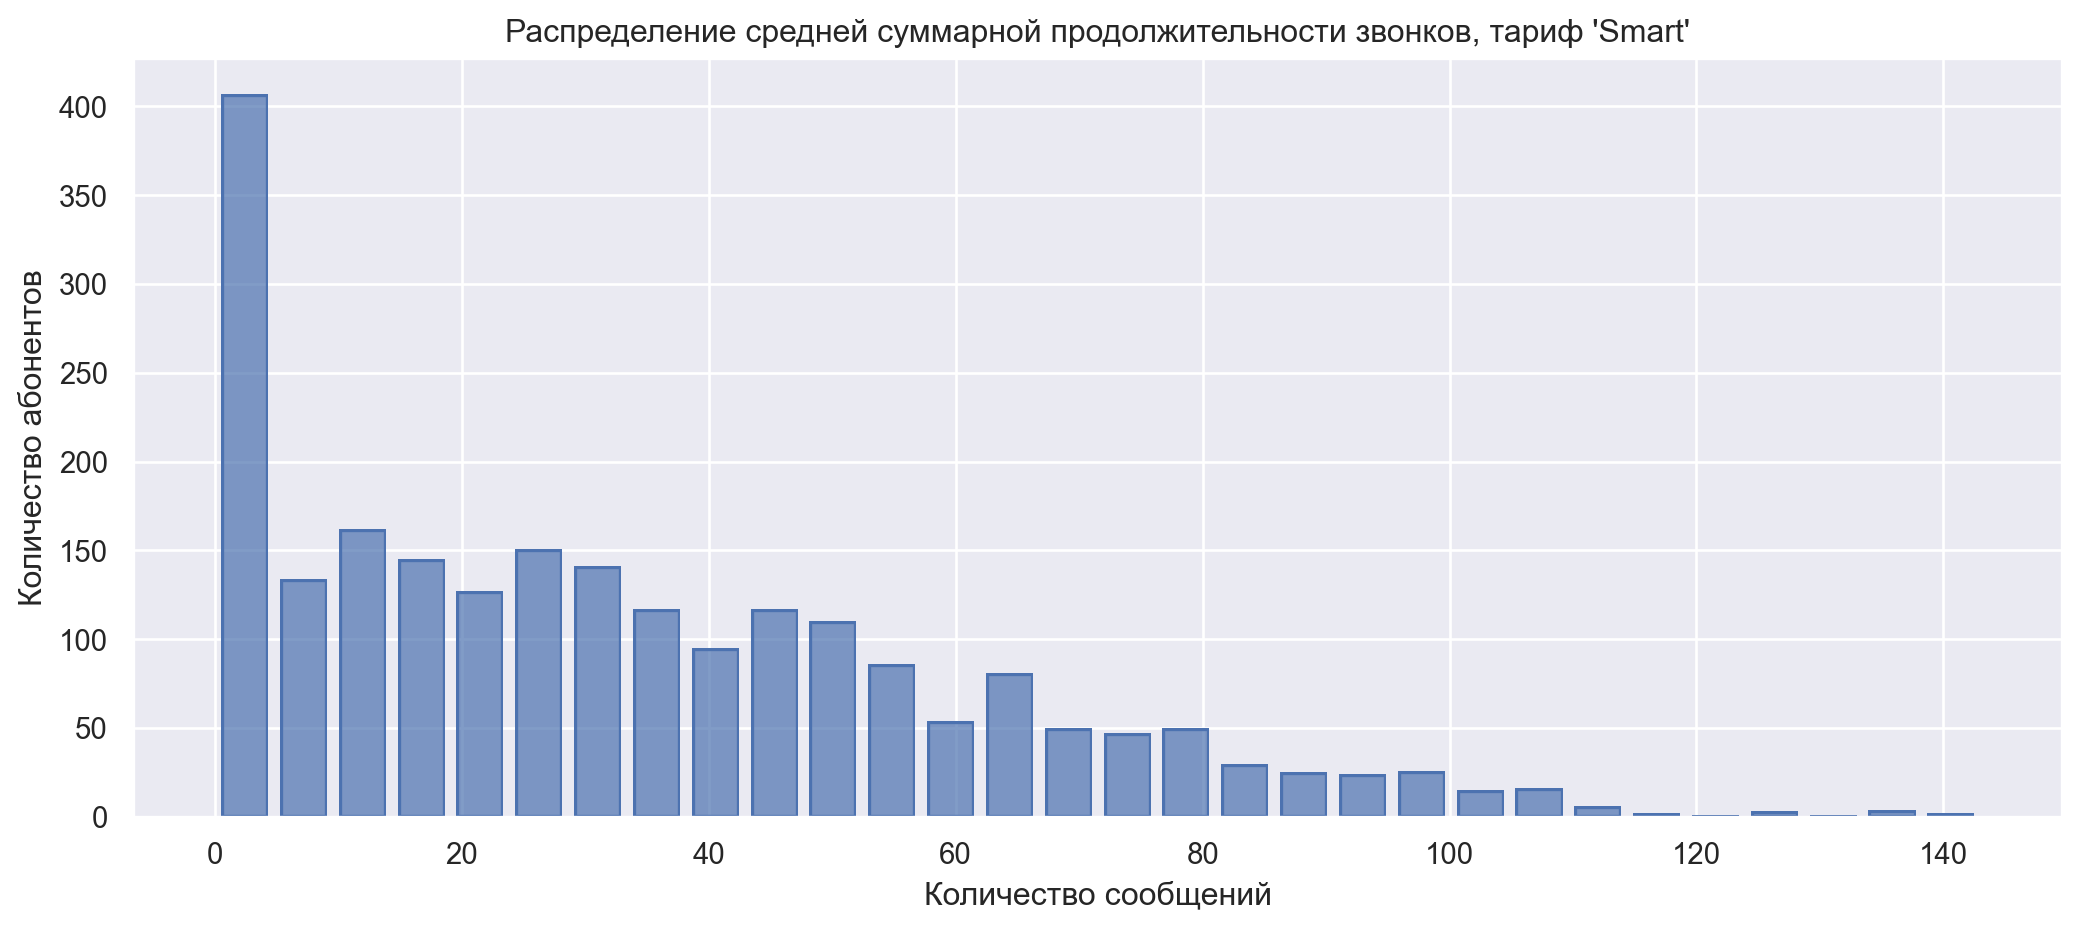

In [62]:
so.Plot(smart['messages_by_month']).add(so.Bar(), so.Hist(bins=30))\
.label(title="Распределение средней суммарной продолжительности звонков, тариф 'Smart'", 
       x="Количество сообщений", y="Количество абонентов").layout(size=(11, 5))

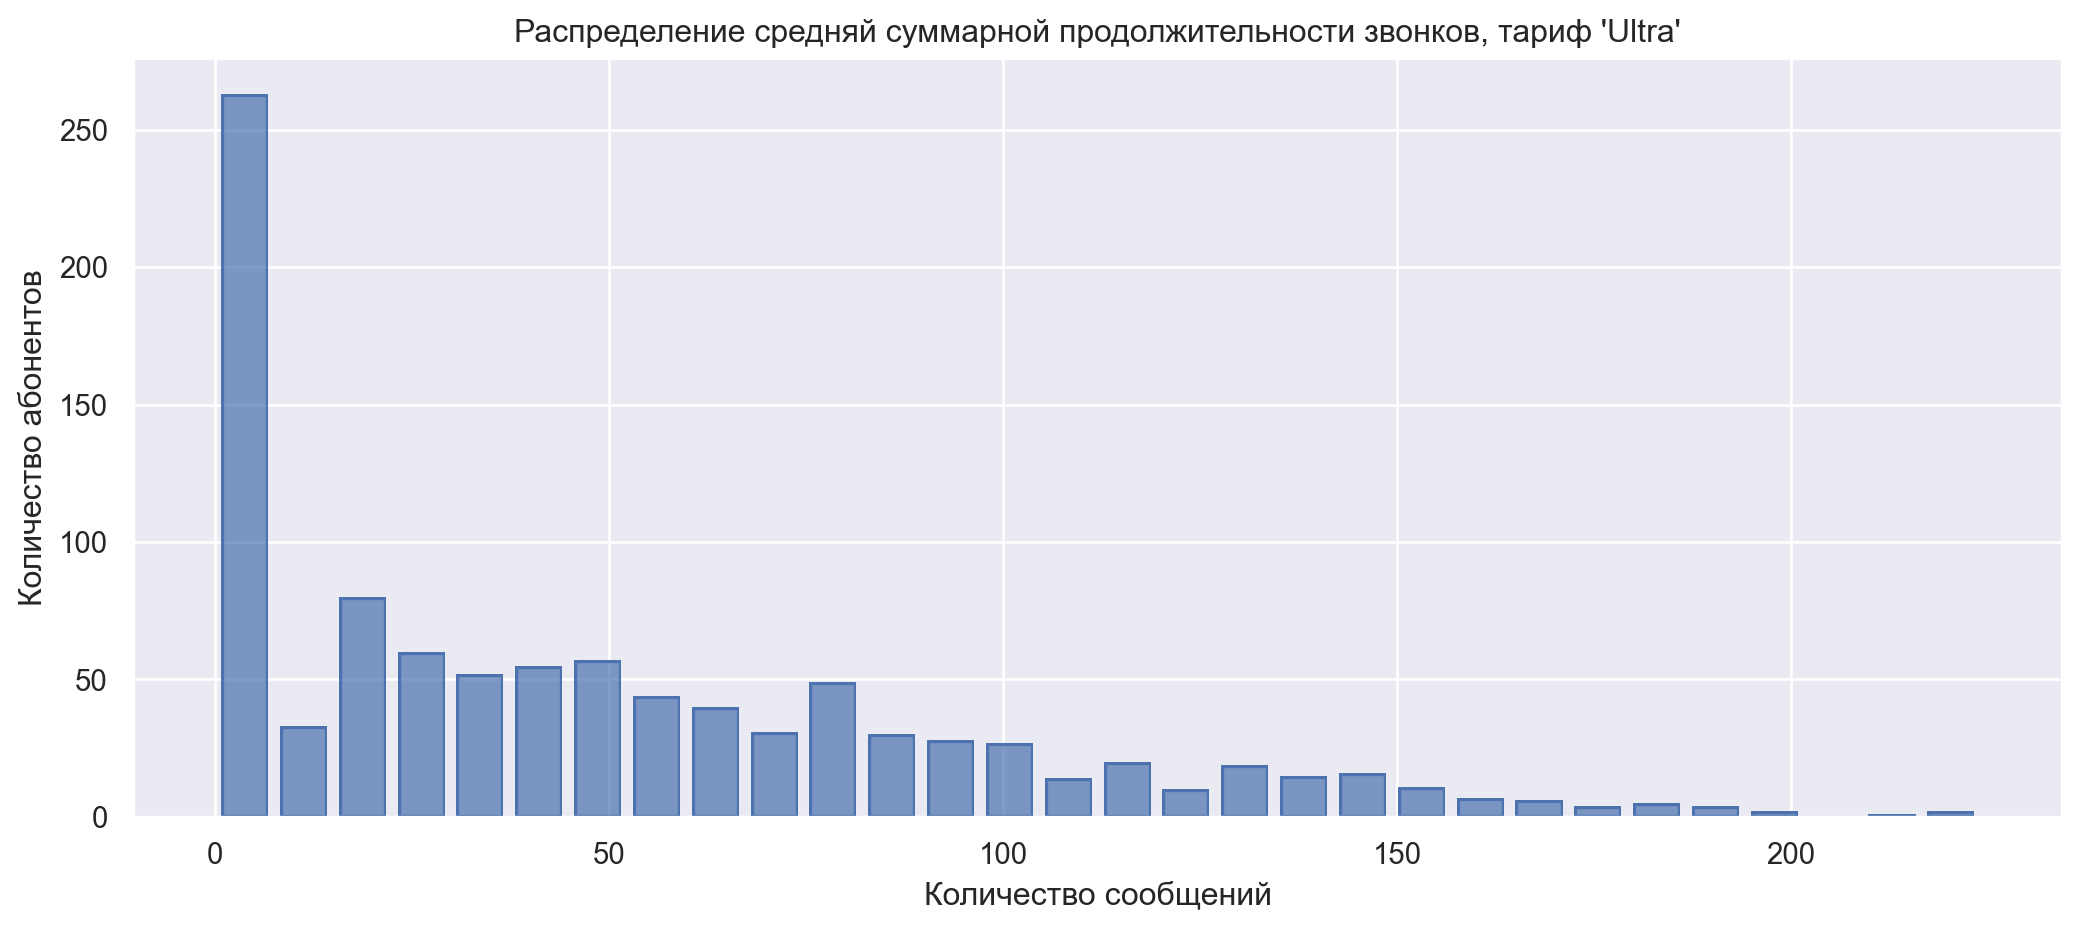

In [63]:
so.Plot(ultra['messages_by_month']).add(so.Bar(), so.Hist(bins=30))\
.label(title="Распределение средняй суммарной продолжительности звонков, тариф 'Ultra'", 
       x="Количество сообщений", y="Количество абонентов").layout(size=(11, 5))

Тренды похожи - большая часть абонентов отправляет до 10 сообщений в каждом тарифе. Однако, есть жирный хвост с абонентами, которые отправляю до 140 и 200 сообщений в `smart` и `ultra` соответственно, но в тарифе `ultra` таких абонентов больше.

In [64]:
smart_messages_mean_by_month = smart.groupby('month').agg({'messages_by_month':['mean','median','var','std']})
smart_messages_mean_by_month

messages_by_month                              
                   mean median         var        std
month                                                
1.0           18.235294   15.0  262.367201  16.197753
2.0           24.086207   20.0  473.097701  21.750809
3.0           31.857143   23.0  718.492481  26.804710
4.0           30.741071   28.0  602.139559  24.538532
5.0           33.773050   30.0  730.990983  27.036845
6.0           33.402439   28.0  806.806374  28.404337
7.0           33.751244   29.0  799.887811  28.282288
8.0           33.638298   27.0  838.257501  28.952677
9.0           33.638462   30.0  790.617820  28.117927
10.0          33.765306   30.0  816.111966  28.567673
11.0          34.075949   28.0  805.937071  28.389031
12.0          35.994065   29.0  934.952346  30.576990

In [65]:
ultra_messages_by_month = ultra.groupby('month').agg({'messages_by_month':['mean','median','var','std']}).reset_index()
ultra_messages_by_month

month messages_by_month                               
                      mean median          var        std
0    1.0         33.777778   32.0   940.694444  30.670742
1    2.0         21.958333    5.5   716.824275  26.773574
2    3.0         32.297297   20.0  1732.381381  41.621886
3    4.0         31.563636   17.0  1407.287542  37.513831
4    5.0         37.850746   25.0  1624.644052  40.306874
5    6.0         41.726190   27.5  1986.297619  44.567899
6    7.0         49.846154   38.0  2372.042735  48.703621
7    8.0         48.439252   40.0  2171.739199  46.601923
8    9.0         52.286957   43.0  2152.855530  46.398874
9   10.0         58.430894   49.0  2697.181661  51.934398
10  11.0         55.791045   43.0  2476.948491  49.768951
11  12.0         60.611511   51.0  2681.978417  51.787821

Построим график со средним количеством сообщений по месяцам для каждого тарифа.

In [66]:
month_messages = users_used_up.pivot_table(
    index=['month', 'tariff'],
    values = 'messages_by_month',
    aggfunc = 'mean'
).reset_index()

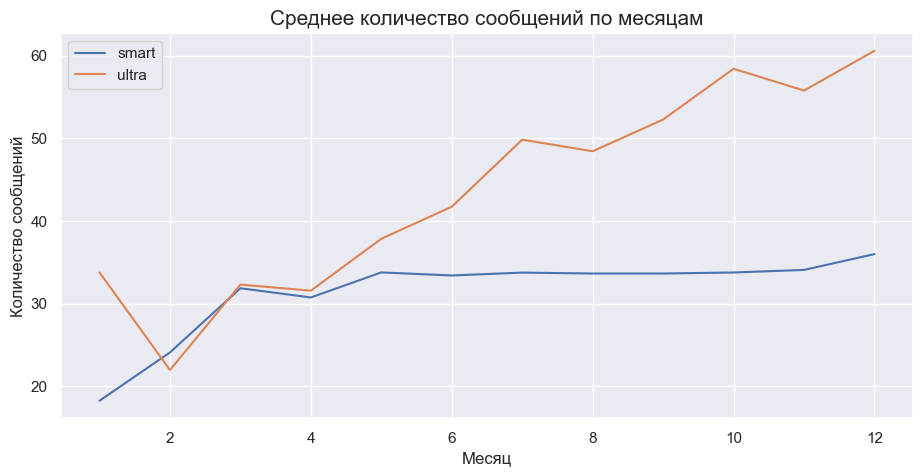

In [67]:
sns.set(rc={'figure.figsize':(11, 5)})
ax = sns.lineplot(data=month_messages, x="month", y="messages_by_month", hue="tariff")
ax.set_title('Среднее количество сообщений по месяцам', fontsize = 15)
ax.set_xlabel("Месяц")
ax.set_ylabel("Количество сообщений")
ax.legend(loc="upper left");

В январе абоненты `ultra` отправляют сообщений больше, чем в полтора раза. С февраля по май отправляют примерно одинаково, а начиная с июня и до конца год разрыв увеличивает, абоненты тарифа `ultra` отправляю всё больше и больше сообщений. С мая и до конца года среднее количество сообщений у `smart` остаётся примерно на одном уровне.

### Трафик: среднее, медиана, дисперсия, стандартное отклонение

Посмотрим как распределён средний использованный трафик по месяцам в тарифах `smart` и `ultra` в целом по году.

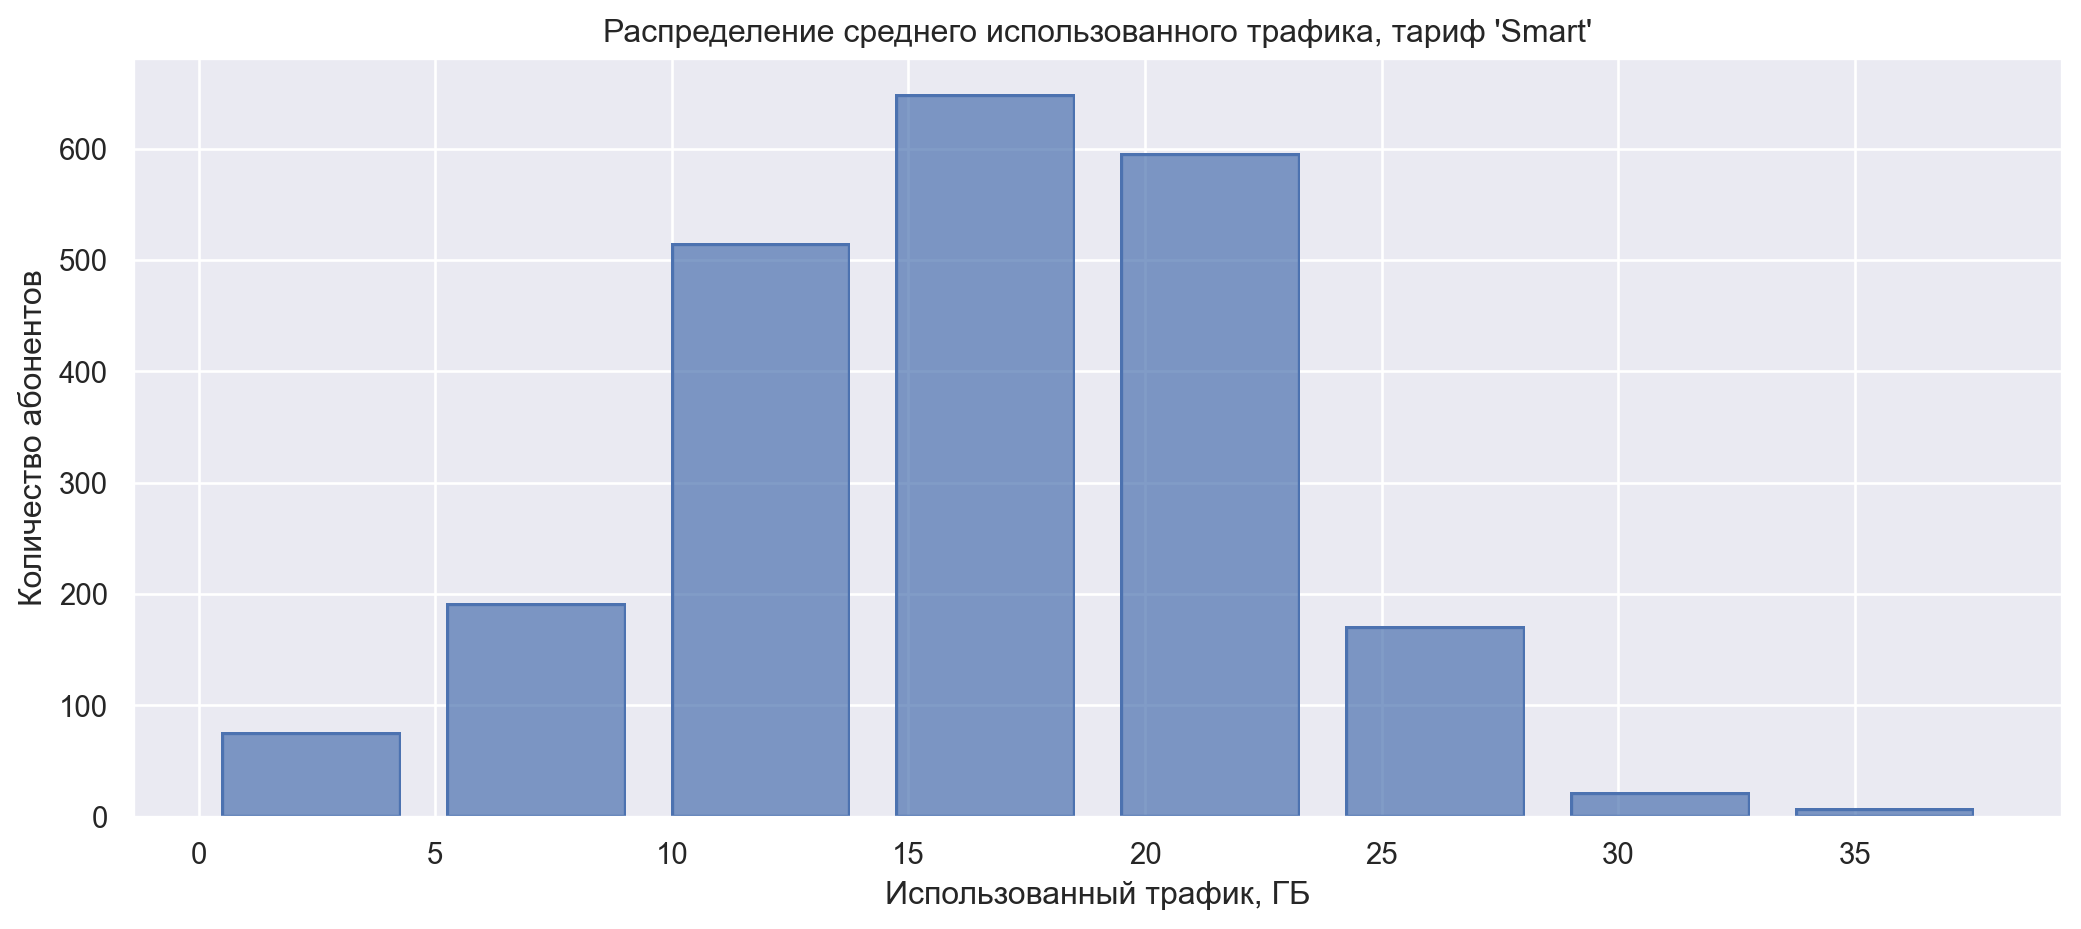

In [68]:
so.Plot(smart['traffic_by_month']).add(so.Bar(), so.Hist(bins=8))\
.label(title="Распределение среднего использованного трафика, тариф 'Smart'", 
       x="Использованный трафик, ГБ", y="Количество абонентов").layout(size=(11, 5))

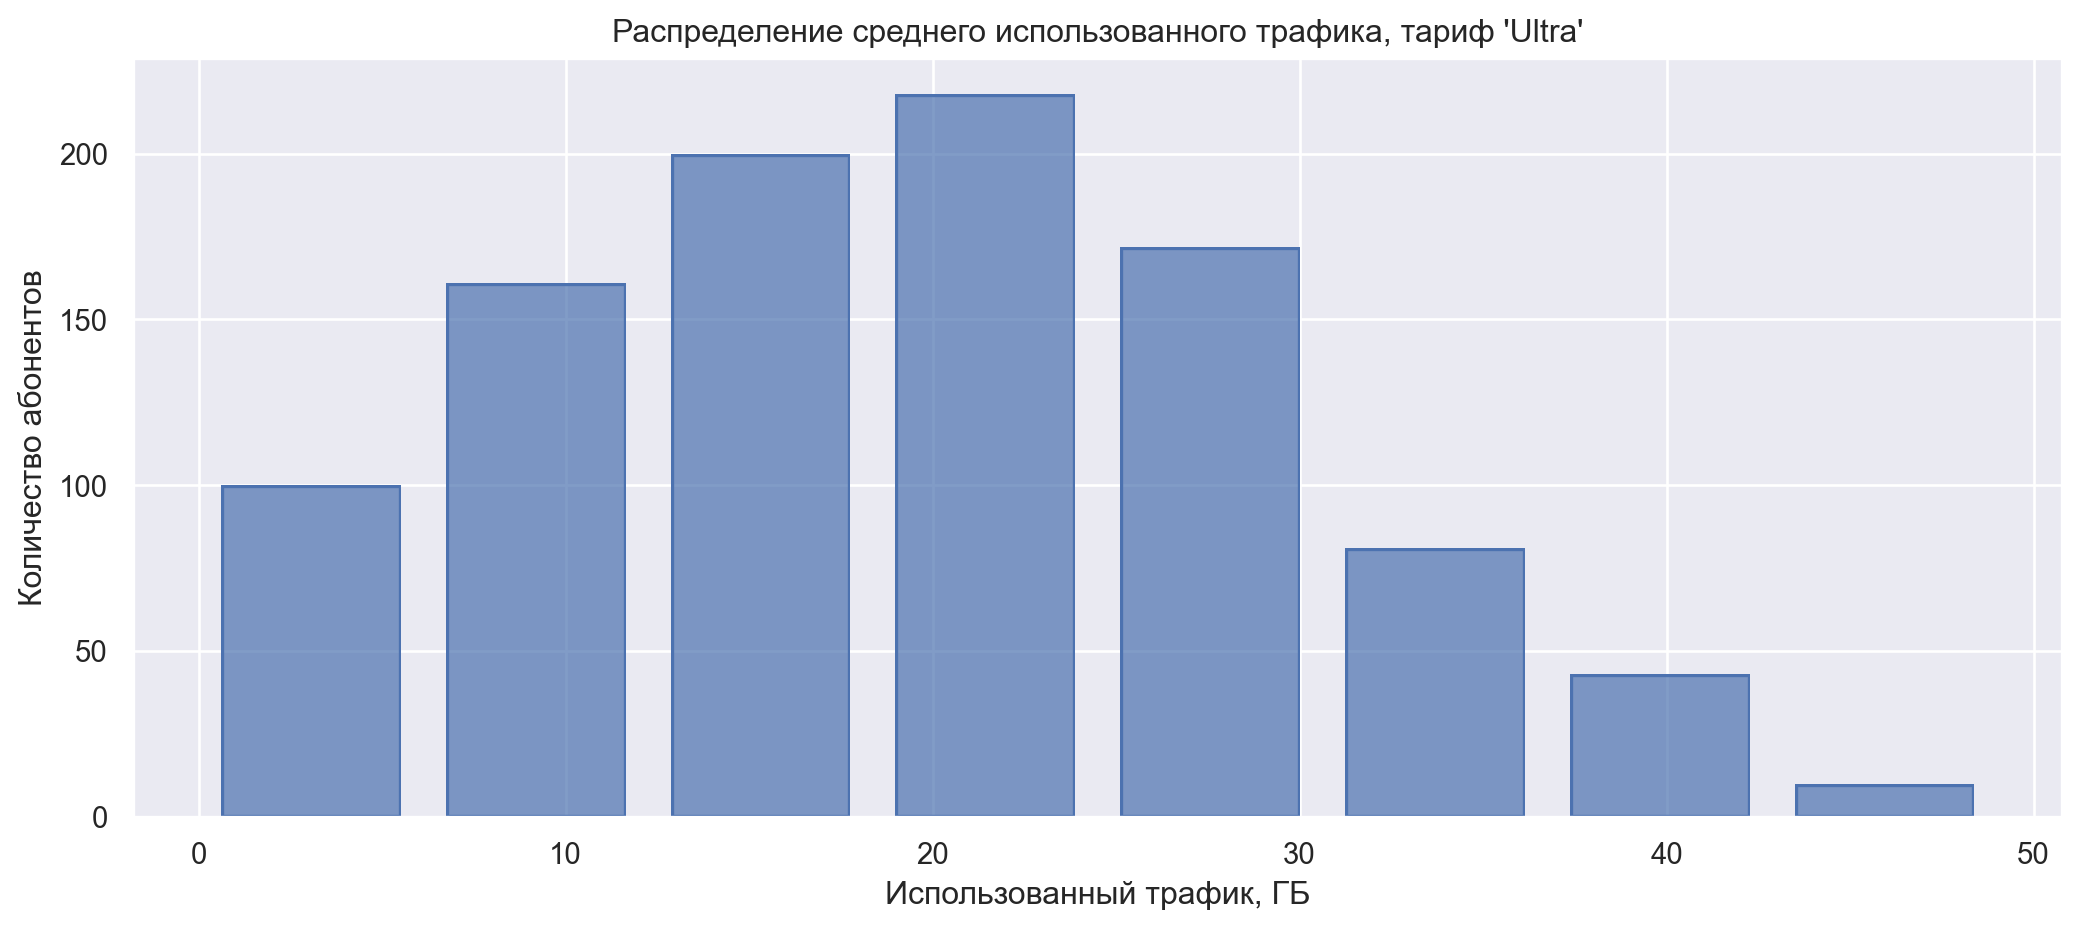

In [69]:
so.Plot(ultra['traffic_by_month']).add(so.Bar(), so.Hist(bins=8))\
.label(title="Распределение среднего использованного трафика, тариф 'Ultra'", 
       x="Использованный трафик, ГБ", y="Количество абонентов").layout(size=(11, 5))

В обоих тарифах пик достикается в диапазоне от 15 до 19 ГБ в месяц. Однако в тарифе `ultra` график смещён вправо,большая доля пользователей в среднем тратит от 25 до 34 ГБ в месяц, а в `smart` таких абонентов крайне мало.

In [70]:
smart_traffic_mean_by_month = smart.groupby('month').agg({'traffic_by_month':['mean','median','var','std']})
smart_traffic_mean_by_month

traffic_by_month                            
                  mean median        var       std
month                                             
1.0           8.735294    7.0  39.412656  6.277950
2.0          11.844828   13.0  37.150938  6.095157
3.0          15.233766   16.0  32.549897  5.705252
4.0          13.625000   14.0  31.299550  5.594600
5.0          15.907801   16.0  34.370010  5.862594
6.0          15.951220   16.0  31.911716  5.649046
7.0          15.875622   16.0  33.419453  5.780956
8.0          16.736170   17.0  30.041207  5.480986
9.0          16.392308   16.0  25.884110  5.087643
10.0         16.880952   17.0  32.897042  5.735594
11.0         17.000000   17.0  27.180952  5.213535
12.0         18.201780   18.0  29.786544  5.457705

In [71]:
ultra_traffic_mean_by_month = ultra.groupby('month').agg({'traffic_by_month':['mean','median','var','std']})
ultra_traffic_mean_by_month

traffic_by_month                              
                  mean median         var        std
month                                               
1.0          13.222222   15.0   44.444444   6.666667
2.0          12.000000    7.5  109.130435  10.446551
3.0          17.648649   18.0  114.345345  10.693238
4.0          16.963636   17.0   89.443098   9.457436
5.0          19.373134   19.0   95.631389   9.779130
6.0          18.940476   19.5   82.394005   9.077114
7.0          20.505495   20.0   96.430525   9.819905
8.0          19.598131   19.0  105.148298  10.254184
9.0          19.243478   20.0   86.255988   9.287410
10.0         20.065041   20.0   91.258030   9.552907
11.0         19.805970   18.5   93.796656   9.684867
12.0         21.741007   22.0  103.236784  10.160550

In [72]:
users_used_up

,user_id,month,calls_duration_by_month,calls_by_month,messages_by_month,traffic_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,0.0,17.0,11.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,550.0
3210,1489,9.0,0.0,0.0,32.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,950.0
3211,1489,10.0,0.0,0.0,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart,1150.0


Построим график со средним использованным трафиокм по месяцам для каждого тарифа.

In [73]:
month_trafic = users_used_up.pivot_table(
    index=['month', 'tariff'],
    values = 'traffic_by_month',
    aggfunc = 'mean'
).reset_index()

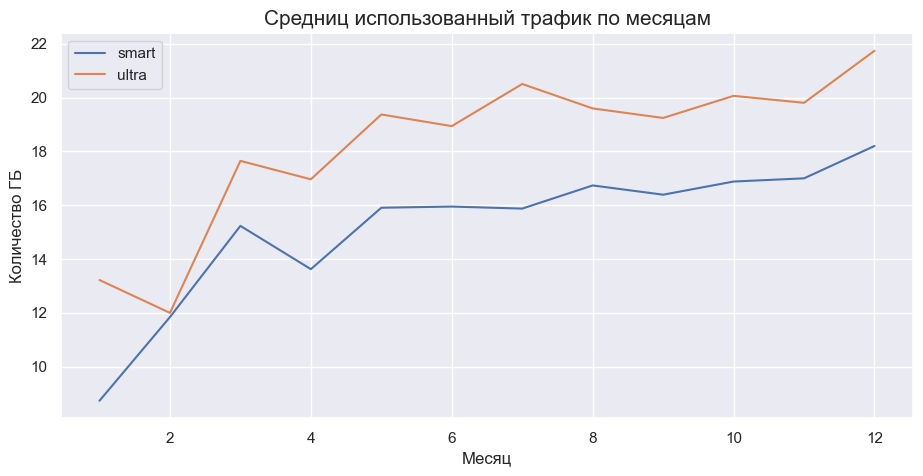

In [74]:
sns.set(rc={'figure.figsize':(11, 5)})
ax = sns.lineplot(data=month_trafic, x="month", y="traffic_by_month", hue="tariff")
ax.set_title('Средниц использованный трафик по месяцам', fontsize = 15)
ax.set_xlabel("Месяц")
ax.set_ylabel("Количество ГБ")
ax.legend(loc="upper left");

Абоненты тарифа `ultra` практически ежемесячно тратят больше трафика, чем абоненты `smart`. В среднем больше на 2-4 ГБ. Только в феврале значения практически одинаковые.

### Выручка

Посмотрим на динамику средней выручки с абонента в течение года.

In [75]:
month_revenue = users_used_up.pivot_table(
    index=['month', 'tariff'],
    values = 'revenue',
    aggfunc = 'mean'
).reset_index()

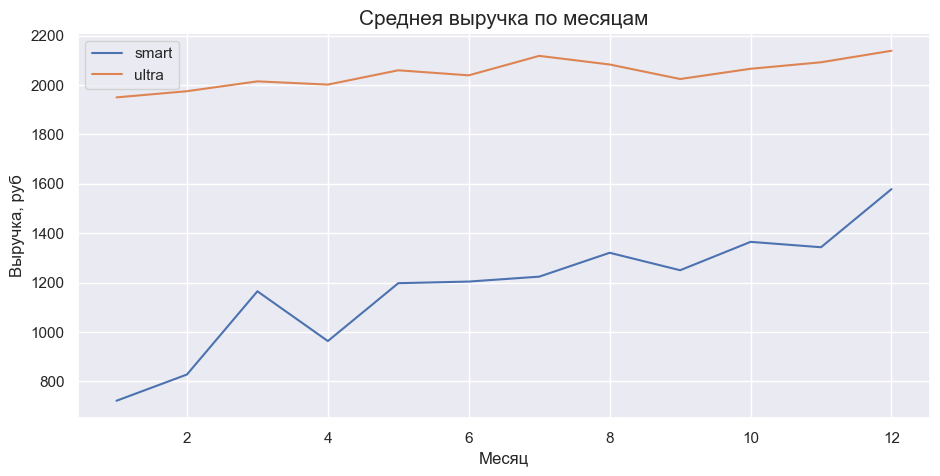

In [76]:
sns.set(rc={'figure.figsize':(11, 5)})
ax = sns.lineplot(data=month_revenue, x="month", y="revenue", hue="tariff")
ax.set_title('Среднея выручка по месяцам', fontsize = 15)
ax.set_xlabel("Месяц")
ax.set_ylabel("Выручка, руб")
ax.legend(loc="upper left");

В течение года средняя выручка по тарифу `ultra` увеличивается плавно с 1950 руб до 2138 руб. В начале года в тарифе `Ultra` выручка больше почти в два раза, чем в `Smart`. Однако в конце года разрыв уменьшается в два раза, так как выручка в тарифе `smart` увеличивается с 721 до 1578 руб.
Двухкратное увеличение выручки в `Smart` происходит за счёт увеличения использования пользователями этого тарифа большего объёма трафика и увлеичения количества и длительности звонков.

Построим сводную таблицу со средними длительностью и количеством звонков, средним количеством сообщений, средним объёмом трафика и средней выручкой за год.

In [77]:
year_mean_values = users_used_up.groupby(['tariff'])\
                       .agg({'calls_duration_by_month': 'mean',
                            'calls_by_month': 'mean',
                            'messages_by_month': 'mean',
                            'traffic_by_month': 'mean',
                            'revenue': 'mean'})\
                            .reset_index()\
                       .rename(columns = {'calls_duration_by_month':'mean_calls_duration_by_year',
                                         'calls_by_month':'mean_calls_by_year',
                                          'messages_by_month':'mean_messages_by_year',
                                          'traffic_by_month':'mean_traffic_by_year',
                                          'revenue':'mean_revenue_by_year'})

In [78]:
year_mean_values

,tariff,mean_calls_duration_by_year,mean_calls_by_year,mean_messages_by_year,mean_traffic_by_year,mean_revenue_by_year
0,smart,417.934948,58.463437,33.384029,16.328847,1289.973531
1,ultra,526.623350,73.392893,49.363452,19.494416,2070.152284


Покажем визуально каждый столбец в разрезе тарифов.

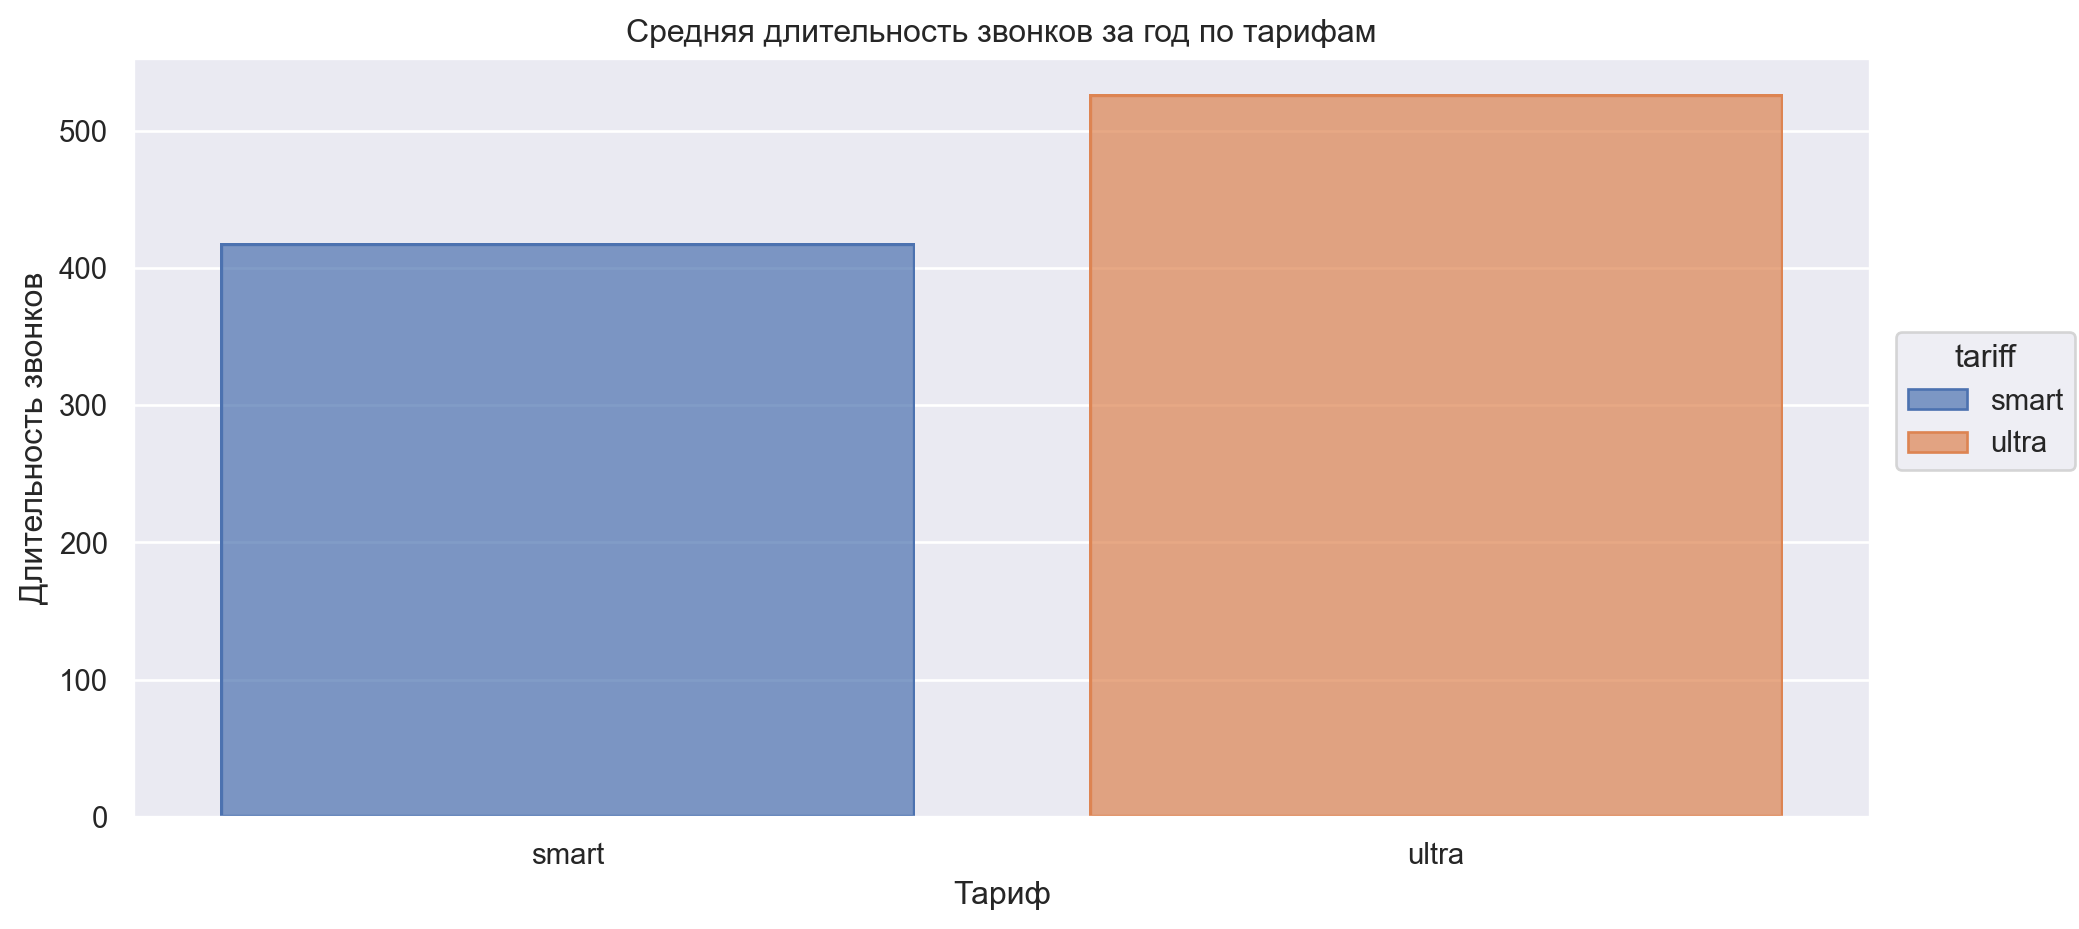

In [79]:
so.Plot(year_mean_values, x="tariff", y="mean_calls_duration_by_year").add(so.Bar(), color = 'tariff')\
.label(title="Средняя длительность звонков за год по тарифам", 
       x="Тариф", y="Длительность звонков").layout(size=(10, 5))

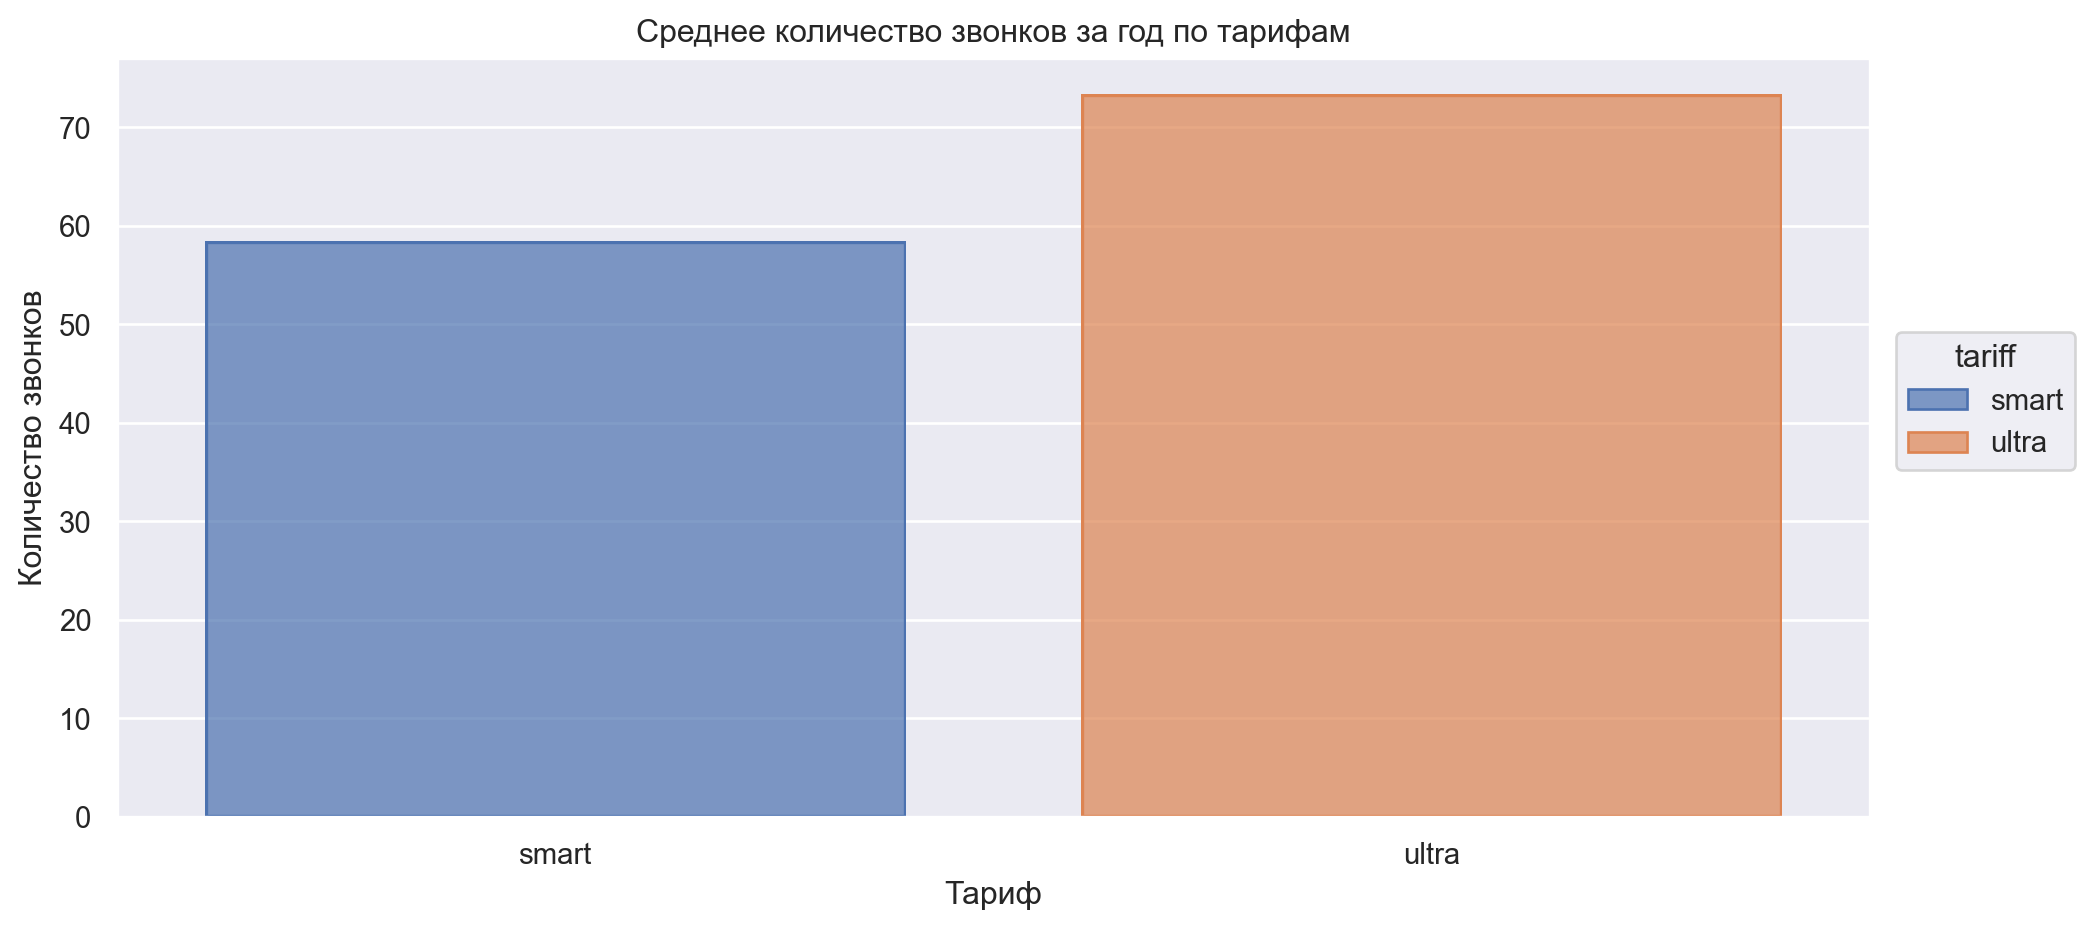

In [80]:
so.Plot(year_mean_values, x="tariff", y="mean_calls_by_year").add(so.Bar(), color = 'tariff')\
.label(title="Среднее количество звонков за год по тарифам", 
       x="Тариф", y="Количество звонков").layout(size=(10, 5))

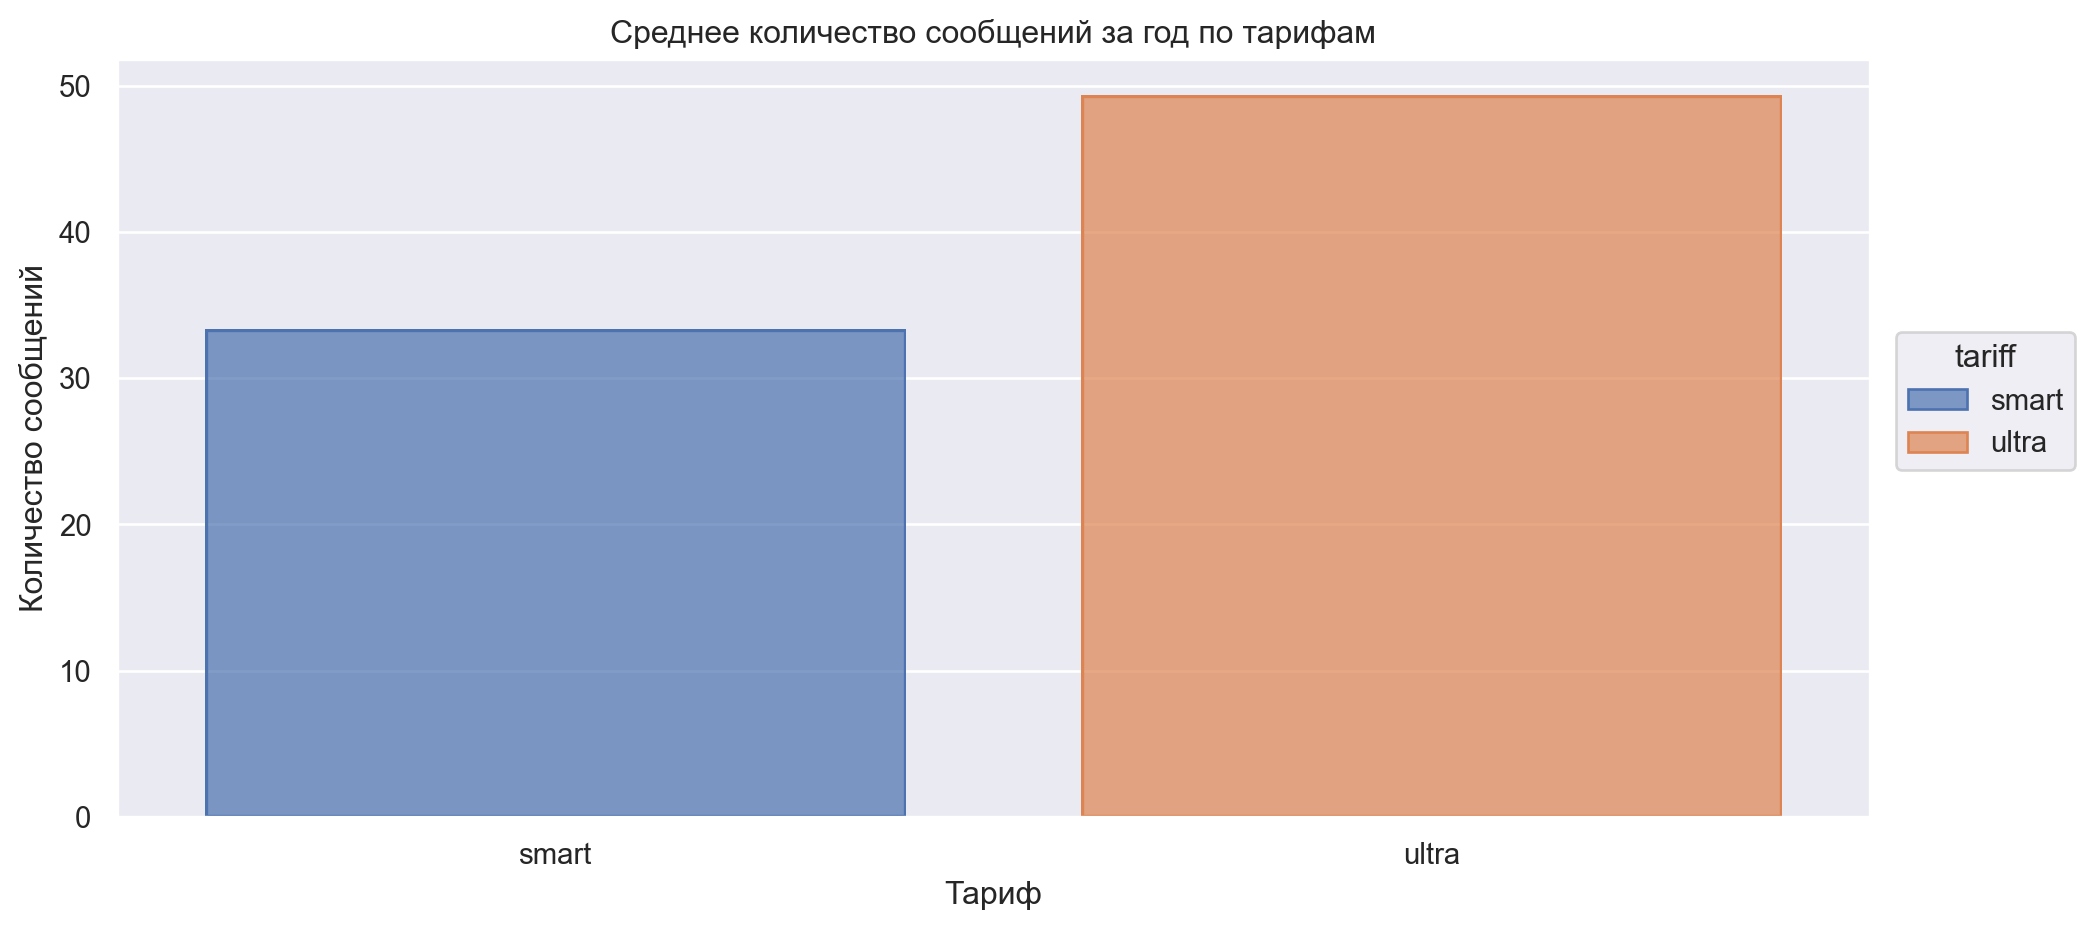

In [81]:
so.Plot(year_mean_values, x="tariff", y="mean_messages_by_year").add(so.Bar(), color = 'tariff')\
.label(title="Среднее количество сообщений за год по тарифам", 
       x="Тариф", y="Количество сообщений").layout(size=(10, 5))

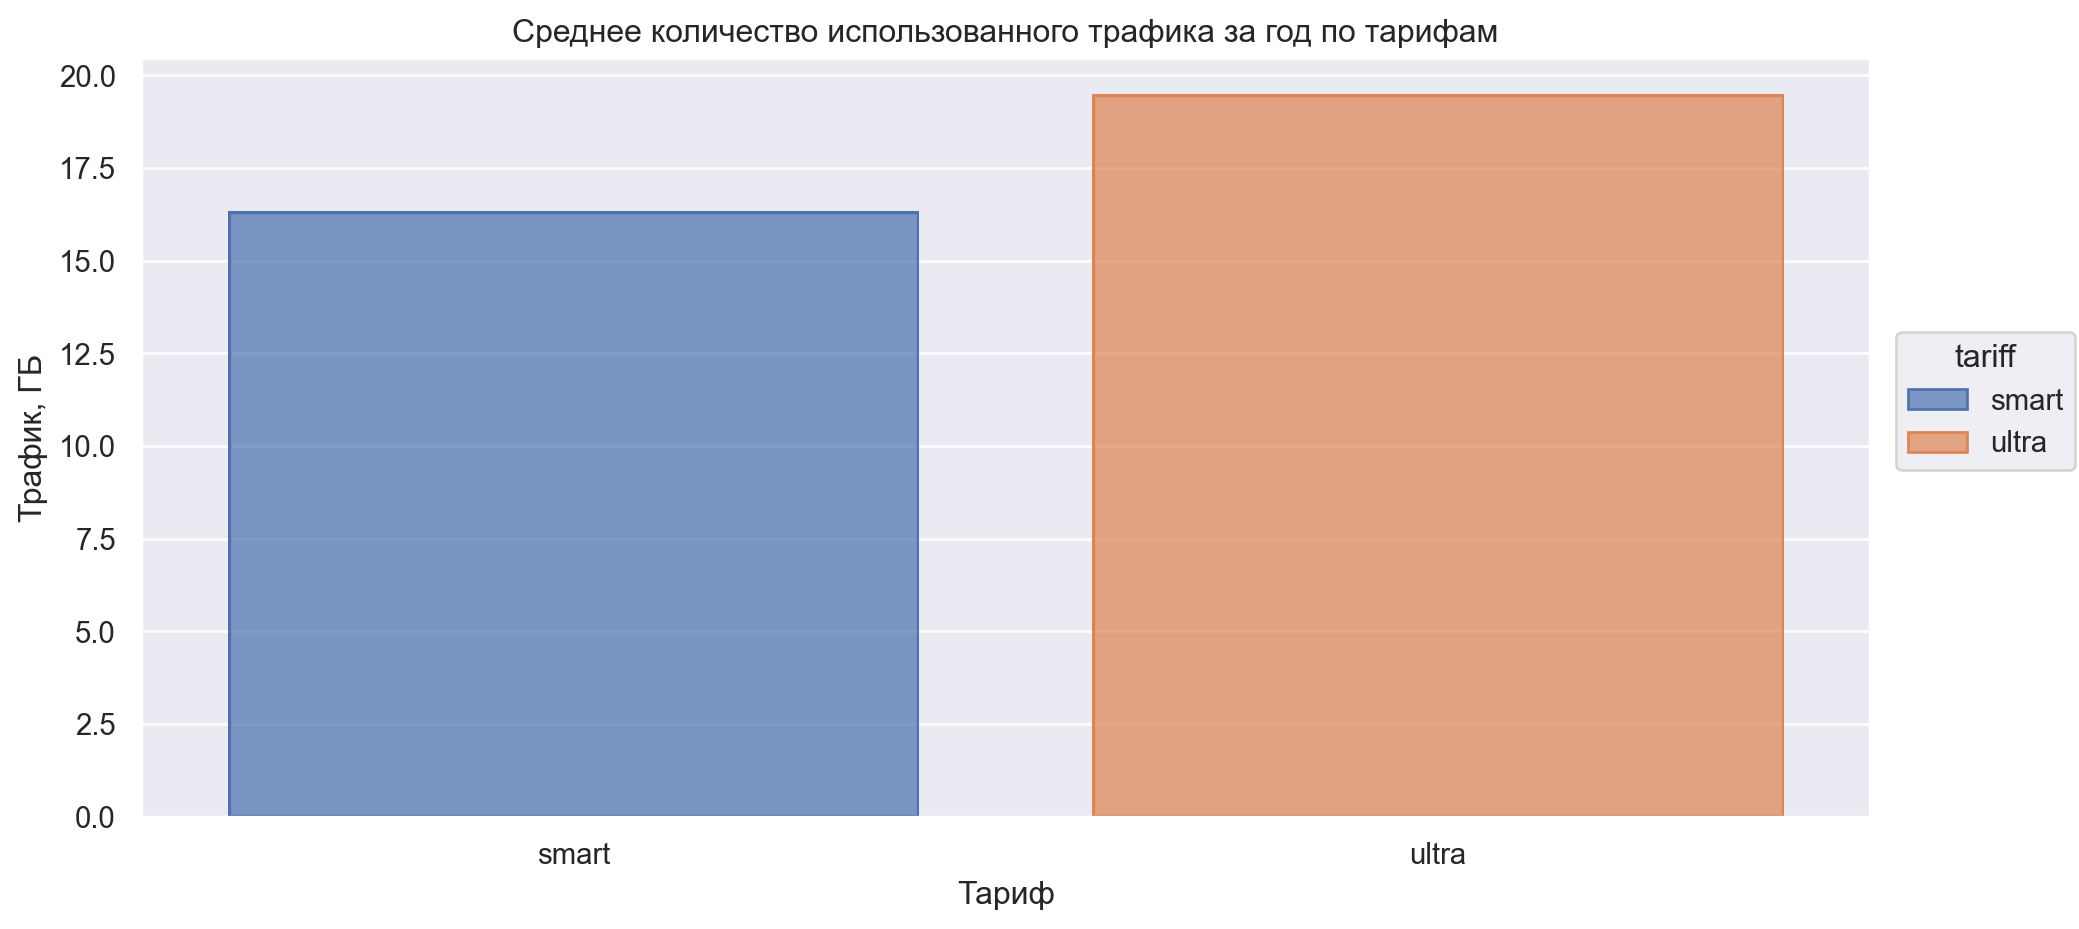

In [82]:
so.Plot(year_mean_values, x="tariff", y="mean_traffic_by_year").add(so.Bar(), color = 'tariff')\
.label(title="Среднее количество использованного трафика за год по тарифам", 
       x="Тариф", y="Трафик, ГБ").layout(size=(10, 5))

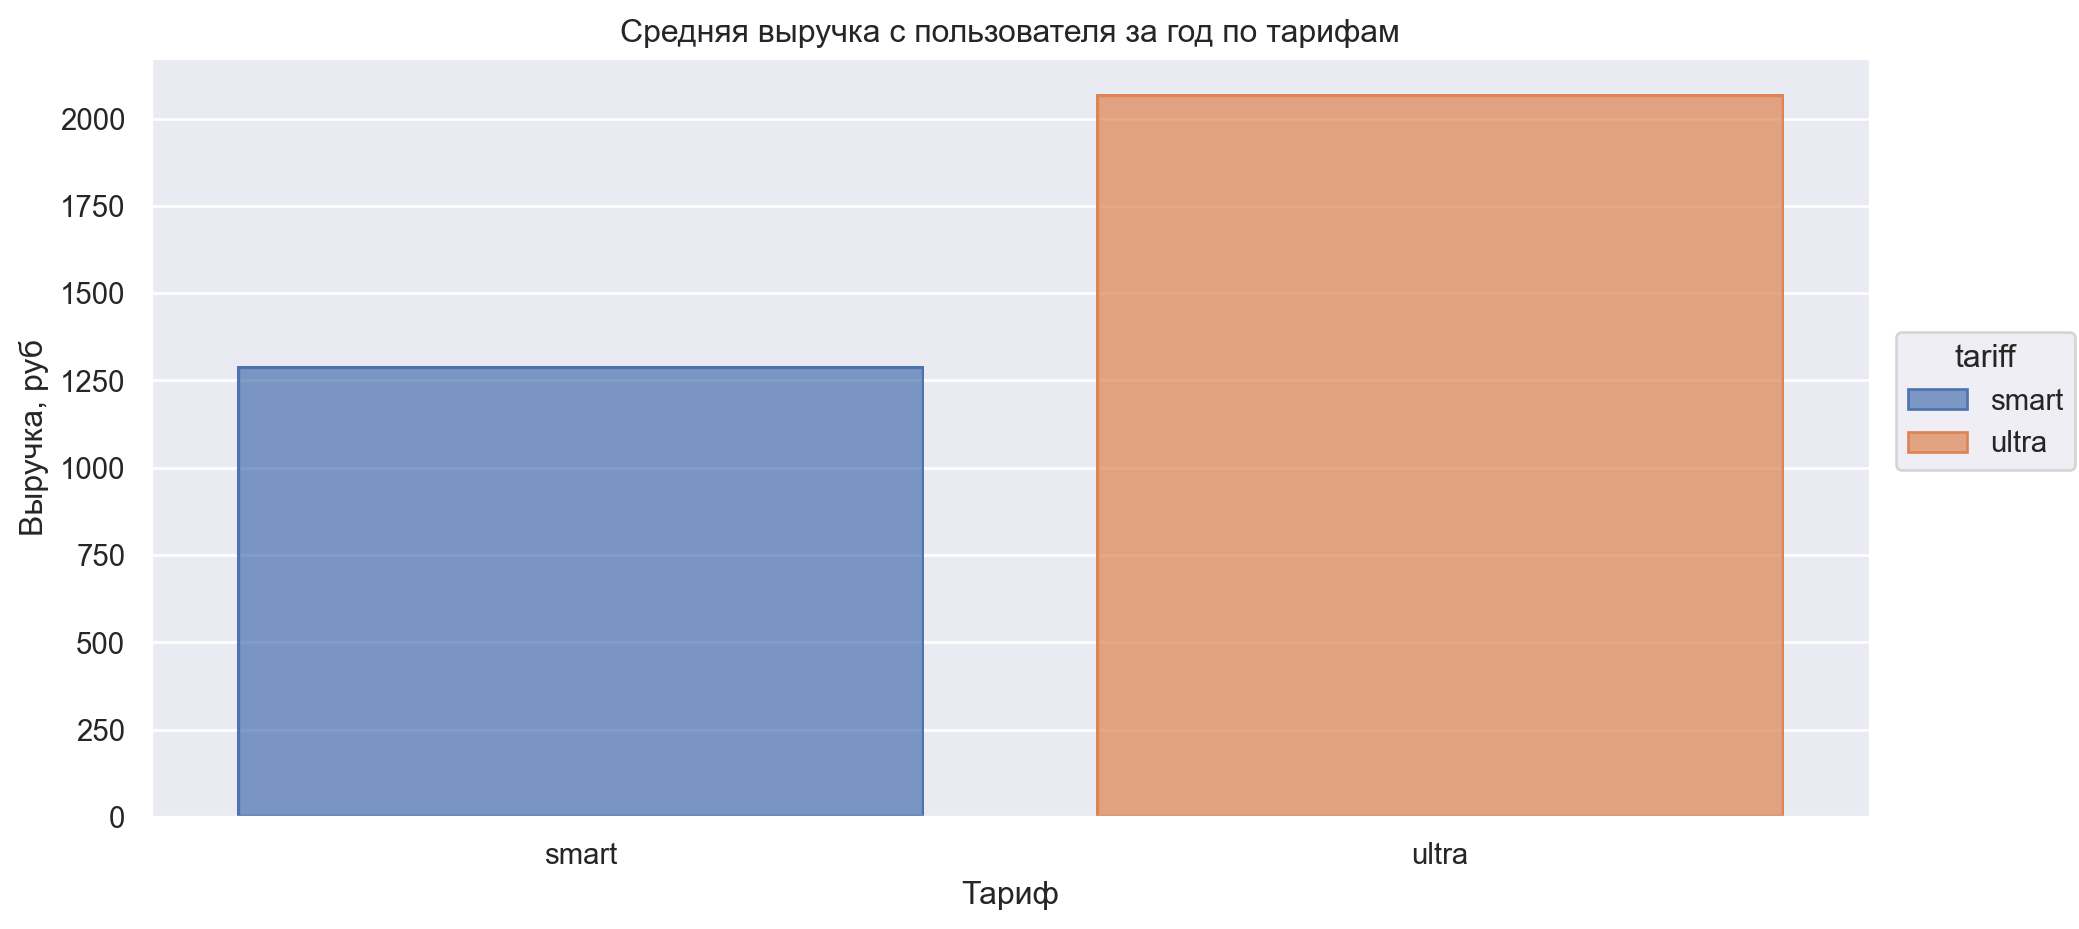

In [83]:
so.Plot(year_mean_values, x="tariff", y="mean_revenue_by_year").add(so.Bar(), color = 'tariff')\
.label(title="Средняя выручка с пользователя за год по тарифам", 
       x="Тариф", y="Выручка, руб").layout(size=(10, 5))

Общая картина по году соответствует тому, что мы увидели, когда рассматривали динамику по месяцам. Пользователи тарифа `ultra` в среднем чаще звонят, дольше разговаривают, тратят больше сообщений и трафика. А также в среднем приносят больше дохода компании.

## Шаг 4. Проверка гипотез

Мы сформулировали две гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение `alpha` задайте самостоятельно.

***Поясните:***

как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

Мы хотим проверить отличаются ли средняя выручка у двух тарифов. Для этого сформулируем нулевую и альтернативные гипотезы:

H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы;

H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Мы буде применять тест для проверки гипотез о равенстве средних двух генеральных совокупностей, так как у нас есть две выборки (тарифы), которые предвставляют ген. совокупности и поведение пользователей не зависит друг от друга.

Выберем сохраним массивы с доходом по каждому тарифу в переменны `smart_revenue` и `ultra_revenue`, значение alpha установим на уровне 5%. Для проведения теста будем использовать метод `scipy.stats.ttest_ind (array1, array2, equal_var)`, параметр равенства дисперсий укажем `False`, так как выборки разных размеров и у нас нет подтверждения, что дисперсии одинаковы.

In [84]:
smart_revenue = smart['revenue']
ultra_revenue = ultra['revenue']

alpha = 0.05

results = st.ttest_ind(
    smart_revenue, 
    ultra_revenue,
    equal_var = False)

print('p-value равняется', results.pvalue) # выведем p-value на экран

results.pvalue < alpha # проверим, меньше ли p-value критического уровня статистической значимости
# если p-value окажется меньше него - отвергнем нулевую гипотезу

p-value равняется 4.2606313931076085e-250


True

**Вывод**

P-value оказалось меньше критического уровня статистической значимости. Значит у нас есть все оснавания, отвергнуть H0 и принять H1. Средние выручки у тарифов Smart и Ultra отличаются.

Вторая гипотеза, которую мы хотим проверить: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для этого сформулируем нулевую и альтернативные гипотезы:

H0 - средние выручки пользователей из Москвы и из других регионов равны;

H1 - средние выручки пользователей из Москвы и из других регионов различаются.

Мы будем применять тот же тест, что и при проверке предыдущей гипотезы. Параметр о равности дисперсий, также установим `False`. Критический урровень статистической значимости alpha установим на уровне 5%.

Сохраним в переменные `moscow_revenue` и `regions_revenue` массивы с выручками в Москве и регионах соответственно.

In [85]:
moscow_revenue = users_used_up[users_used_up['city'] == 'Москва']['revenue']
regions_revenue = users_used_up[users_used_up['city'] != 'Москва']['revenue']

alpha = 0.05

results = st.ttest_ind(
    moscow_revenue, 
    regions_revenue,
    equal_var = False)

print('p-value равняется', results.pvalue) # выведем p-value на экран

results.pvalue < alpha # проверим, меньше ли p-value критического уровня статистической значимости
# если p-value окажется меньше него - отвергнем нулевую гипотезу

p-value равняется 0.5257376663729298


False

**Вывод**

P-value оказалось выше критического уровня статистической значимости. Значит у нас нет оснаваний, отвергнуть H0 и принять H1. Средние выручки в Москве и регионах не отличаются.

## Общие выводы

#### Обзор данных

Форматы данных в порядке, даты мы преобразовали в момент загрузки. 
В churn_date запонено 38 значений, остальные - NaN, то есть дата пропущена. 
Значит большинство тарифов за исключением 38 случаев действовало на момент выгрузки данных. 
В остальных столбцах пропусков нет.

В датафрейме 202607 строк. Столбцов с пропусками нет. Форматы данных в порядке.

В таблице 149396 записей об интернет-сессиях. Пропусков нет. Форматы данных в порядке.

В описаниях наших тарифов все значения целочисленные, кроме назваия тарифа. Типы данных в порядке. 
Информация соответствует, тому, что предоставил заказчик.

В данных нет пропусков. Типы данных во всех таблицах приведены к нужному формату. 


#### Предобработка данных

Аномалий и дубликатов в наших данных нет. Единственной, что мы сделали - удалили строки, где за интернет-сессию совсем не было израсходовано трафика. 
Заказчик предоставил доставточо чистые данные.

**Мы провели необходимые расчёты для исследовательского анализа по звонкам, сообщениям, трафиком и выручкой.**

#### Исследовательский анализ данных

**Длительность и количество звонков**

В обоих тарифах пик достигается в промежутке 400-500 минут в месяц. Однако в тарифе ultra в целом значения сдвинуты вправо. 
Достаточно большая часть пользователей наговаривает от 800 до 1400 минут в месяц, чего не скажешь о пользователях тарифы smart. 
Значит длительность звонков в этом тарифе больше. 
Также в тарифе ultra есть значительное количество абонентов, которые разговаривали менеее 200 минут в месяц, в тарифе smart доля таких пользователей меньше.
В обоих тарифах пик достигается в промежутке 400-500 минут в месяц. Однако в тарифе ultra в целом значения сдвинуты вправо. 
Достаточно большая часть пользователей наговаривает от 800 до 1400 минут в месяц, чего не скажешь о пользователях тарифы smart. Значит длительность звонков в этом тарифе больше. 
Также в тарифе ultra есть значительное количество абонентов, которые разговаривали менеее 200 минут в месяц, в тарифе smart доля таких пользователей меньше.

В тарифе ultra средняя суммарная продолжительность звонков больше. Только в одном месяце этот показатель находится в диапазоне от 200 до 300 минут. 
4 месяца в диапазоне от 400 до 500 минут, и 7 месяцев в диапазоне от 500 до 600 минут.

Средняя продолжительность по месяцам и среднее количество звонков в тарифе ultra выше, чем в тарифе smart.

**Сообщения**

Большая часть абонентов отправляет до 10 сообщений в каждом тарифе. 
Однако, есть жирный хвост с абонентами, которые отправляю до 140 и 200 сообщений в smart и ultra соответственно, но в тарифе ultra таких абонентов больше.

В январе абоненты ultra отправляют сообщений больше, чем в полтора раза. 
С февраля по май отправляют примерно одинаково, а начиная с июня и до конца год разрыв увеличивает, абоненты тарифа ultra отправляю всё больше и больше сообщений. 
С мая и до конца года среднее количество сообщений у smart остаётся примерно на одном уровне.

**Трафик**

В обоих тарифах пик достикается в диапазоне от 15 до 19 ГБ в месяц. 
Однако в тарифе ultra график смещён вправо,большая доля пользователей в среднем тратит от 25 до 34 ГБ в месяц, а в smart таких абонентов крайне мало.

Абоненты тарифа ultra практически ежемесячно тратят больше трафика, чем абоненты smart. 
В среднем больше на 2-4 ГБ. Только в феврале значения практически одинаковые.

**Выручка**

В течение года средняя выручка по тарифу `ultra` увеличивается плавно с 1950 руб до 2138 руб. В начале года в тарифе `Ultra` выручка больше почти в два раза, чем в `Smart`. Однако в конце года разрыв уменьшается в два раза, так как выручка в тарифе `smart` увеличивается с 721 до 1578 руб.
Двухкратное увеличение выручки в `Smart` происходит за счёт увеличения использования пользователями этого тарифа большего объёма трафика и увлеичения количества и длительности звонков.

####  Проверка гипотез

**Первая гипотеза**

Мы проверили отличаются ли средняя выручка у двух тарифов. Для этого сформулировали нулевую и альтернативные гипотезы:

H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы;

H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Мы применли тест для проверки гипотез о равенстве средних двух генеральных совокупностей, 
так как у нас есть две выборки (тарифы), которые предвставляют ген. совокупности и поведение пользователей не зависит друг от друга.
значение alpha установили на уровне 5%. 

Статистический тест показал, что P-value оказалось меньше критического уровня статистической значимости. 
Значит у нас есть все оснавания, отвергнуть H0 и принять H1. Вывод - средние выручки у тарифов Smart и Ultra отличаются.

**Вторая гипотеза**

Мы проверили отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов.

Для этого сформулировали нулевую и альтернативные гипотезы:

H0 - средние выручки пользователей из Москвы и из других регионов равны;

H1 - средние выручки пользователей из Москвы и из других регионов различаются.

Мы применили тот же тест, что и при проверке предыдущей гипотезы.
Критический урровень статистической значимости alpha установили на уровне 5%.

Статистический тест показал, что P-value оказалось выше критического уровня статистической значимости. 
Значит у нас нет оснаваний, отвергнуть H0 и принять H1. Средние выручки в Москве и регионах не отличаются.

## Главный вывод и рекомендация

Пользователи тарифа Ultra в среднем больше звонят, отправляют сообщений и используют интернет-трафика. Компания получает от них больший доход. 
Рекомендация заказчику - нужно увеличивать количество и долю пользователей тарифа Ultra.

Также поьзователи тарифа `Smart` показали двукратный рост выручки в конце года по сравнению с началом года. Если в будущем динамика останется такой же, то пользователи этого тарифа смогут обогнать пользователей `Ultra` по выручке.